In [1]:
!python -V

Python 3.10.11


In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '8'
os.environ['VECLIB_MAXIMUM_THREADS'] = '8'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ["MKL_NUM_THREADS"] = '6' # export MKL_NUM_THREADS=6
os.environ["NUMEXPR_NUM_THREADS"] = '6' # export NUMEXPR_NUM_THREADS=6

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
import scipy as sp
from matplotlib import gridspec
import matplotlib
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

import pickle
import pgzip
import os, psutil

from IPython.display import display, clear_output

from joblib import Parallel, delayed
N_JOBS=2
from tqdm.notebook import tqdm
# from tqdm import tqdm
from datetime import datetime

import pyfftw
nthreads=2

%config InlineBackend.figure_format = 'retina'
# %config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'pdf'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
# warnings.filterwarnings("ignore", category=UserWarning) 
warnings.formatwarning = lambda s, *args: "Warning: " + str(s)+'\n'

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [4]:
np.show_config()

blas_armpl_info:
  NOT AVAILABLE
blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_armpl_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/opt/homebrew/Caskroom/miniforge/base/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
Supported SIMD extensions in this NumPy install:
    baseline = NEON,NEON_FP16,NEON_VFPV4,ASIMD
    found = 

In [5]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [6]:
from numba import njit, jit, prange, objmode, vectorize
import numba
numba.set_num_threads(8)

In [7]:
from numba_progress import ProgressBar

In [8]:
from matplotlib.ticker import MaxNLocator

In [9]:
import gc
gc.enable(  )
# gc.set_debug(gc.DEBUG_SAVEALL)

In [10]:
print(np.finfo(np.clongdouble))
print(np.finfo(np.cdouble))
print(np.finfo(np.csingle))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-30

In [11]:
dtype = np.cdouble
dtyper = np.float64

In [12]:
use_cache = False
datatime_now = datetime.now()
output_prefix_bracket = "("+datatime_now.strftime("%Y%m%d-%H%M%S") + "-" + \
                        str("T" if use_cache else "F") + ")"
output_prefix = "output/entangled_halo_proj/"+output_prefix_bracket+" "
output_ext = ".pgz.pkl"
print(output_prefix)

output/entangled_halo_proj/(20231015-012335-F) 


In [13]:
import platform
if not use_cache:
    with open(output_prefix + "session_info.txt", "wt") as file:
        string = ""
        string += ("="*20 + "Session System Information" + "="*20) + "\n"
        string += "Current Time: "+datatime_now.strftime("%Y %b %d %a - %H:%M:%S")+"\n"
        uname = platform.uname()
        string +=  f"Python Version: {platform.python_version()}\n"
        string +=  f"Platform: {platform.platform()}\n"
        string += (f"System: {uname.system}")+ "\n"
        string += (f"Node Name: {uname.node}")+ "\n"
        string += (f"Release: {uname.release}")+ "\n"
        string += (f"Version: {uname.version}")+ "\n"
        string += (f"Machine: {uname.machine}")+ "\n"
        string += (f"Processor: {uname.processor}")+ "\n"
        string +=  f"CPU Counts: {os.cpu_count()} \n"
    #     print(string)
        file.write(string)

## Simulation Parameters

In [14]:
nx = 120+1
nz = 120+1
xmax = 20 # Micrometers
# xmax = 20 * 0.001 # Millimeters
# zmax = (nz/nx)*xmax
zmax = 20
dt = 5e-4 # Milliseconds
# dt = 1e-5 # Seconds
# dt = 0.1 # Microseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
# hb = 0.0635077993 # ("AtomicMassUnit" ("Micrometers")^2)/("Microseconds")
# hb = 0.0000635077993 #  ("AtomicMassUnit" ("Millimeters")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print("zmax =", zmax)
print("(dx,dz) =", (dx, dz) ) 
print("rotate phase =", 1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print("pxmax =", pxmax)
print("pzmax =", pzmax)
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
print("(dpx,dpz) = ", (dpx, dpz))

print(round((nx*nz)**2/1000/1000,3),"million grid points (ideally want around 1M magnitude)")
print(round(2*8*(nx*nz)**2/1000/1000,3),"MB of data needed estimate")
print(round(5*2*8*(nx*nz)**2/1000/1000,3),"MB of RAM needed to run this thing (estimate)")
print(round((nx*nz)**2*0.001*0.001/60, 2),"minutes/grid_op (for 1μs/element_op)")

assert ((nx*nz)**2 < 1000**4), "This is in the terra range! too big!"


zmax = 20
(dx,dz) = (0.3333333333333333, 0.3333333333333333)
rotate phase = 0.0357231375j
pxmax = 608.5226956732322
pzmax = 608.5226956732322
(dpx,dpz) =  (9.975781896282493, 9.975781896282493)
214.359 million grid points (ideally want around 1M magnitude)
3429.742 MB of data needed estimate
17148.71 MB of RAM needed to run this thing (estimate)
3.57 minutes/grid_op (for 1μs/element_op)


In [15]:
warnings.warn(str(round(5*2*8*(nx*nz)**2/1000/1000/1000,3)) + " GB of RAM needed to run this thing (estimate)")

In [16]:
wavelength = 1.083 #Micrometers
# k = (1/sqrt(2)) * 2*pi / wavelength # effective wavelength
# k = 0.03 * 2*pi / wavelength
k = pi / (2*dx)
# k = pi / (2*dz)
p = 2*hb*k
print("k  =",k,"1/µm")
print("p  =",p, "u*µm/ms")
v3 = hb*k/m3
v4 = hb*k/m4
print("v3 =",v3, "µm/ms")
print("v4 =",v4, "µm/ms")
print("sigma_x =", hb/10, " handwavy heisenberg momentum uncertainty ")
print(2*pi / (2*k), "x-period of cosin bragg lattice")

# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"
assert (dpx < hb/2 and dpz < hb/2), "momentum resolution step too big"
# assert (2*pi / (2*k) > 10*dx), "not even ten x-steps in cosin wave!"

k  = 4.71238898038469 1/µm
p  = 598.5469137769496 u*µm/ms
v3 = 99.75781896282494 µm/ms
v4 = 74.8183642221187 µm/ms
sigma_x = 6.35078  handwavy heisenberg momentum uncertainty 
0.6666666666666666 x-period of cosin bragg lattice


AssertionError: momentum resolution too small

In [17]:
# dopd = 60.1025 # 1/ms Doppler detuning (?)
dopd = v3**2 * m3 / hb
print(dopd)
warnings.warn("why? TODO: check")

470.0976467876271


In [18]:
pi / (8*dx)

1.1780972450961724

In [19]:
a4 = 0.007512 # scattering length 
omega = 50 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggPi = np.sqrt(2*pi*hb)/V0
# tBraggCenter = 1
tBraggCenter = tBraggPi * 5
tBraggEnd = tBraggPi * 10
print("V0 =", V0)
print("tBraggPi     =", round(tBraggPi,3),"µs")
print("tBraggCenter =", round(tBraggCenter,3),"µs")
print("tBraggEnd    =", round(tBraggEnd,3),"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)

def VB(t, tauMid, tauPi):
        return V0 * (2*pi)**-0.5 * tauPi**-1 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)

V0F = 50*1000
def VBF(t, tauMid, tauPi, V0FArg=V0F):
        return V0FArg * (2*pi)**-0.5 * np.exp(-0.5*(t-tauMid)**2 * tauPi**-2)
    
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max(V)")

pxlin = np.linspace(-pxmax,+pxmax,nx,dtype=dtyper)
pzlin = np.linspace(-pzmax,+pzmax,nz,dtype=dtyper)

V0 = 6350.780000000001
tBraggPi     = 0.003 µs
tBraggCenter = 0.016 µs
tBraggEnd    = 0.031 µs
7.873048664888407e-06j term infront of Bragg potential
6.341670455467974j max(V)


In [20]:
warnings.warn("The code below probably will take " + str(round(5*2*8*(nx*nz)**2/1000/1000/1000,3)) + " GB RAM")

assert 5*2*8*(nx*nz)**2/1000/1000/1000 < 10, " Catch! (stops run all cell - continuing may break the computer!) "

AssertionError:  Catch! (stops run all cell - continuing may break the computer!) 

In [21]:
print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

NameError: name 'psi' is not defined

In [22]:
process = psutil.Process(os.getpid())
def current_py_memory(): return process.memory_info().rss;
def current_py_memory_print(): print(str(round(current_py_memory()/1000**2,3)) + "MB of system memory used")

In [23]:
xlin = np.linspace(-xmax,+xmax, nx, dtype=dtyper)
zlin = np.linspace(-zmax,+zmax, nz, dtype=dtyper)
# psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
# psi=np.random.rand(nx,nz, nx,nz) + 1j*np.random.rand(nx,nz, nx,nz)
# print(round(psi.nbytes/1000/1000 ,3) , "MB per psi 2d*2d array")

In [24]:
current_py_memory_print()

252.871MB of system memory used


In [27]:
xgrid = np.tensordot(xlin, np.ones(nz, dtype=dtyper), axes=0)
cosXGrid = np.cos(2*k*xgrid)
# x3grid = np.tensordot(xgrid, np.ones((nx,nz),dtype=dtyper), axes=0)
# x4grid = np.tensordot(np.ones((nx,nz),dtype=dtyper), xgrid, axes=0)
# cosX3Grid = np.cos(2*k*x3grid)
# cosX4Grid = np.cos(2*k*x4grid)

momory_bytes = current_py_memory()
if (momory_bytes/1000**3 > 1): 
    warnings.warn(str(round(momory_bytes/1000**3,3))+" GB of system memory used already! careful!")
else:
    print(momory_bytes/1000**2 , "MB of system memory used")
del momory_bytes

NameError: name 'current_py_memory' is not defined

In [30]:
current_py_memory_print()

263.324MB of system memory used


### Contact Potential?

In [25]:
(dx,dz)

(0.3333333333333333, 0.3333333333333333)

In [42]:
# # a34 = 0.029 #µm
# a34 = 0.5 #µm
# strength34 = 1e5 # I don't know

In [26]:
((nx-1)/2,(nz-1)/2)

(60.0, 60.0)

In [27]:
current_py_memory_print()

252.92MB of system memory used


### Checking parameters

78


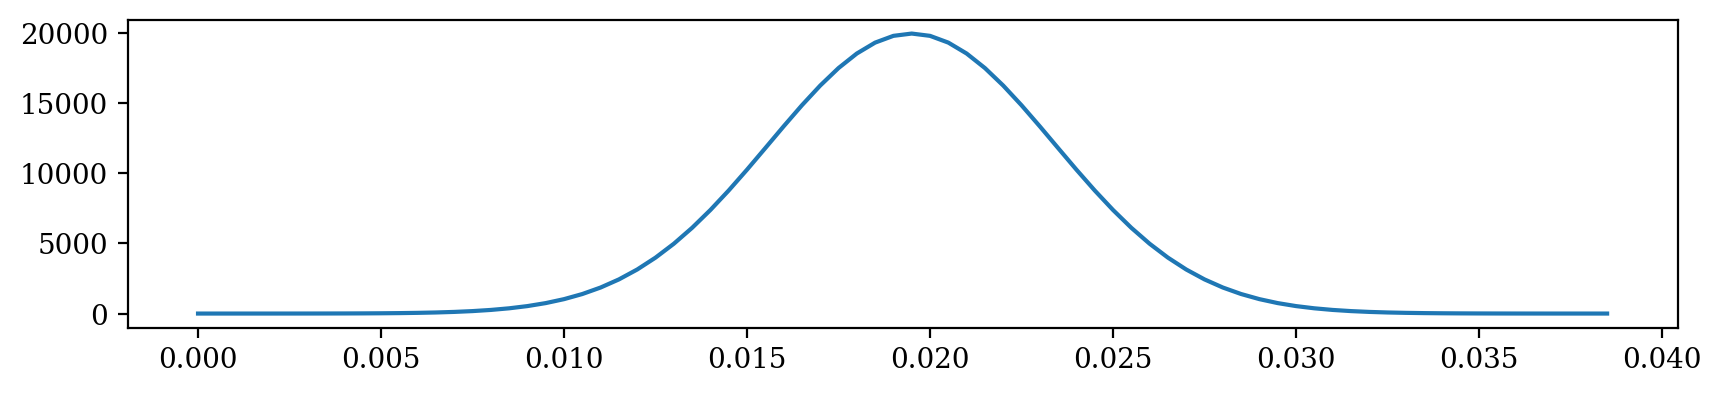

In [28]:
tauPi  = 39*0.0001
tauMid = tauPi*5
tauEnd = tauPi*10

# smooth bragg in time
tbtest = np.arange(0, tauEnd,dt)
# plt.plot(tbtest, V(tbtest))
print(tbtest.size)
plt.figure(figsize=(10,2))
plt.plot(tbtest, VBF(tbtest,tauMid,tauPi))

NameError: name 'cosXGrid' is not defined

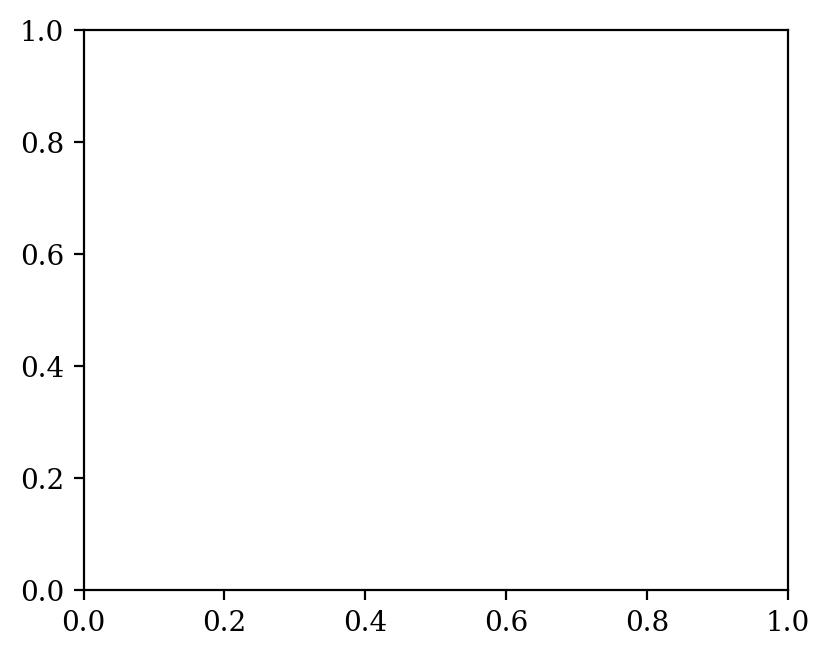

In [29]:
# vtest = np.cos(2*k*xlin)
ncrop = int(0.3*nx)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(cosXGrid.T)
plt.title("bragg potential grid smooth?")

plt.subplot(2,2,2)
plt.imshow(cosXGrid[:ncrop,:ncrop].T)
plt.title("grid zoomed in")

plt.subplot(2,2,3)
plt.plot(cosXGrid[:,0],alpha=0.9,linewidth=0.5)

plt.subplot(2,2,4)
plt.plot(cosXGrid[:ncrop,0],alpha=0.9,linewidth=0.5)

title="bragg_potential_grid"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)

plt.show()
del ncrop
del cosXGrid

## initial wave function

In [23]:
dx

0.3333333333333333

In [29]:
sg = 8;
# @njit(parallel=True, fastmath=True)
# @jit('c16[::1](f8[::1],f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,)')
@njit(cache=True)
def psi0gaussianNN(x3, z3, x4, z4, sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0.0, pz3=0.0, px4=0.0, pz4=0.0):
    return    np.exp(-0.5*x3**2/sx3**2)\
            * np.exp(-0.5*z3**2/sz3**2)\
            * np.exp(-0.5*x4**2/sx4**2)\
            * np.exp(-0.5*z4**2/sz4**2)\
            * np.exp(+(1j/hb)*(px3*x3 + pz3*z3 + px4*x4 + pz4*z4))

# @njit(parallel=True, fastmath=True)
# @jit('f8(c16[::4],f8,f8)', forceobj=True)
# @jit(forceobj=True)
@njit(cache=True)
def check_norm(psi,dx=dx,dz=dz) -> dtyper:
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2))))*(dx*dx*dz*dz)
#     return  np.trapz(
#                 np.trapz(
#                     np.trapz(
#                         np.trapz(np.abs(psi)**2,
#                             dx=dz,axis=numba.literally(3)),
#                         dx=dx,axis=numba.literally(2)),
#                     dx=dz,axis=numba.literally(1))
#                 ,dx=dx,axis=numba.literally(0))
#     with objmode(psi='intp[:]',dx='intp[:]',dz='intp[:]'):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     out = -1
#     with objmode(out='intp[:]'):
#         out = np.trapz(np.trapz(np.trapz(np.trapz(np.abs(psi)**2,dx=dz,axis=3),dx=dx,axis=2),dx=dz,axis=1),dx=dx,axis=0)
#     return out
        
# @njit(parallel=True, fastmath=True)
# @njit(parallel=True)

# @njit(parallel=True)
# def psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin):
#     psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
#     return psi

@njit(parallel=True, cache=True)
# @njit(cache=True)
def psi0gaussian(sx3=sg, sz3=sg, sx4=sg, sz4=sg, px3=0, pz3=0, px4=0, pz4=0, xlin=xlin,zlin=zlin) -> np.ndarray:
#     psi =  psi0gaussian_loop_helper(sx3,sz3,sx4,sz4,px3,pz3,px4,pz4,xlin,zlin)
    psi=np.zeros((nx,nz, nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin, z3, x4, z4,sx3,sz3,sx4,sz4,px3,pz3,px4,pz4)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

# @njit(parallel=True)
@jit(forceobj=True)
# @njit
def only3(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dz,axis=3),dx=dx,axis=2)
#     return np.trapz(np.trapz(np.abs(psi)**2,axis=3),axis=2)*(dx*dz)

# @njit(parallel=True)
@jit(forceobj=True)
def only4(psi):
    return np.trapz(np.trapz(np.abs(psi)**2 ,dx=dx,axis=0),dx=dz,axis=0)



In [25]:
psi0gaussian.signatures

[]

In [30]:
# @njit(parallel=True)
# def psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
#     return psi


@njit(parallel=True, cache=True)
# @jit(forceobj=True)
# @njit(cache=True)
def psi0_just_opposite(dr=20,s3=sg,s4=sg,pt=0,a=0,xlin=xlin,zlin=zlin):
    dr3 = 0.5 * dr;
    dr4 = 0.5 * (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
    ph = 0.5 * pt;
    px = +ph * cos(a)
    pz = +ph * sin(a)
    
#     print((+px,+pz,-px,-pz))
#     psi = psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin)
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0gaussianNN(xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px,+pz,-px,-pz)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)
    

In [31]:
@njit(cache=True)
def psi0PairNN(x3,z3,x4,z4,dr=20,s3=sg,s4=sg,pt=p,a=0):
    dr3 = 0.5 * dr;
    dr4 = 0.5 * (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
    ph = 0.5 * pt;
    px3 = +ph * cos(a)
    pz3 = +ph * sin(a)
    px4 = -ph * cos(a)
    pz4 = -ph * sin(a)
    return (psi0gaussianNN(x3-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+px3,+pz3,+px4,+pz4) + 
            psi0gaussianNN(x3+dx3,z3+dz3, x4-dx4,z4-dz4, s3,s3, s4,s4,-px3,-pz3,-px4,-pz4)
           )

# @njit(parallel=True)
# def psi0Pair_loop_helper(dr,s3,s4,pt,a,xlin=xlin,zlin=zlin):
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
# #     for (iz3, z3) in enumerate(zlin):
#     for iz3 in prange(nz):
#         z3 = zlin[iz3]
#         for (ix4, x4) in enumerate(xlin):
#             for (iz4, z4) in enumerate(zlin):
#                 psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     return psi

@njit(cache=True, parallel=True)
# @njit(cache=True)
def psi0Pair(dr=20,s3=sg,s4=sg,pt=p,a=0,nx=nx,nz=nz):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
    normalisation = check_norm(psi)
    #print(normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)

In [32]:
@njit(nogil=True,parallel=True,cache=True) # psi0Pair already parallelised
# @njit(nogil=True,cache=True)
# @njit(cache=True)
def psi0ring_loop_helper(dr,s3,s4,pt,an, 
#                         ):
                         progress_proxy=None):
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
    angles_list = np.linspace(0,pi,an+1)[:-1]
#     print(an, psi.shape)
    for ia in range(an):
        a = angles_list[ia]
        # print("working on a = "+str(round(a/pi,4))+" * pi      ",end='\r')
#         print(psi0Pair(dr=dr,s3=s3,s4=s4,pt=pt,a=a).shape)
        psi += (1/an) * psi0Pair(dr=dr,s3=s3,s4=s4,pt=pt,a=a,nx=nx,nz=nz)
#         psi_un = psi0Pair_loop_helper(dr=dr,s3=s3,s4=s4,pt=pt,a=a)
        if progress_proxy != None:
            progress_proxy.update(1)
    return psi.astype(dtype)

# @jit(cache=True,forceobj=True)
def psi0ring_with_logging(dr=20,s3=3,s4=3,pt=p,an=4):   
#     psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
#         for (ix4, x4) in enumerate(xlin):
#             print("working on "+str((iz3,ix4))+"      ",end='\r')
#             for (iz4, z4) in enumerate(zlin):
#                 for a in np.linspace(0,2*pi,360):
#                     psi[:,iz3,ix4,iz4] += psi0PairNN(xlin, z3, x4, z4, dr,s3,s4,pt,a)
#     angles_divs = 4
    angles_list = np.linspace(0,pi,an+1)[:-1]
    
#     if logging:
    print("angles_list = "+ str(np.round(angles_list/pi,4)) + " * pi")
    with ProgressBar(total=an) as progress:
        psi = psi0ring_loop_helper(dr,s3,s4,pt,an,progress)
#     psi = psi0ring_loop_helper(dr,s3,s4,pt,an)
    normalisation = check_norm(psi)
#     print(" ")
#     print("normalisation =", normalisation)
    return (psi/sqrt(normalisation)).astype(dtype)
#     else:
# #         for a in angles_list:
# #             psi += (1/an) * psi0Pair(dr=dr,s3=s3,s4=s4,pt=p,a=a)
#         psi = psi0ring_loop_helper(dr,s3,s4,pt,an,None)
#         normalisation = check_norm(psi)
#         return psi/sqrt(normalisation)
    
# @njit(cache=True)
def psi0ring(dr=20,s3=3,s4=3,pt=p,an=4):   
    psi = psi0ring_loop_helper(dr,s3,s4,pt,an)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

In [33]:
_ = psi0ring_with_logging(dr=20,s3=3,s4=3,pt=p,an=1)
_ = psi0ring(dr=20,s3=3,s4=3,pt=p,an=1)

angles_list = [0.] * pi


  0%|                                                                                                         …

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x15f910040>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [33]:
gc.collect()

1043

#### Testings

In [ ]:
su = 4
psi = psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=-100, pz3=-50, px4=100, pz4=50)
t = 0

tempTest3 = only3(psi)
tempTest4 = only4(psi)
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
tempTest3phi = only3phi(phi)
tempTest4phi = only4phi(phi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(tempTest3.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(tempTest4.T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow((tempTest3phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow((tempTest4phi.T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
del tempTest3, tempTest4, tempTest3phi, tempTest4phi
current_py_memory_print()

In [ ]:
tempTest3phi = only3phi(phi)

#### Testings v2

In [46]:
print(22*32/60, "min")

11.733333333333333 min


In [47]:
# su = 4
# psi = psi0Pair(dx=20,s3=su,s4=su,pt=0,a=0)
# del psi
psi = psi0ring_with_logging(dr=5,s3=1.7,s4=1.7,pt=2*hb*k,an=32)
t = 0

angles_list = [0.     0.0312 0.0625 0.0938 0.125  0.1562 0.1875 0.2188 0.25   0.2812
 0.3125 0.3437 0.375  0.4063 0.4375 0.4687 0.5    0.5312 0.5625 0.5938
 0.625  0.6562 0.6875 0.7188 0.75   0.7812 0.8125 0.8438 0.875  0.9062
 0.9375 0.9688] * pi


  0%|                                                                                                         …

check normalisation psi 1.0000000000000002
check normalisation phi 0.9999999999999997
swnf = (535.3202428349596+0j)


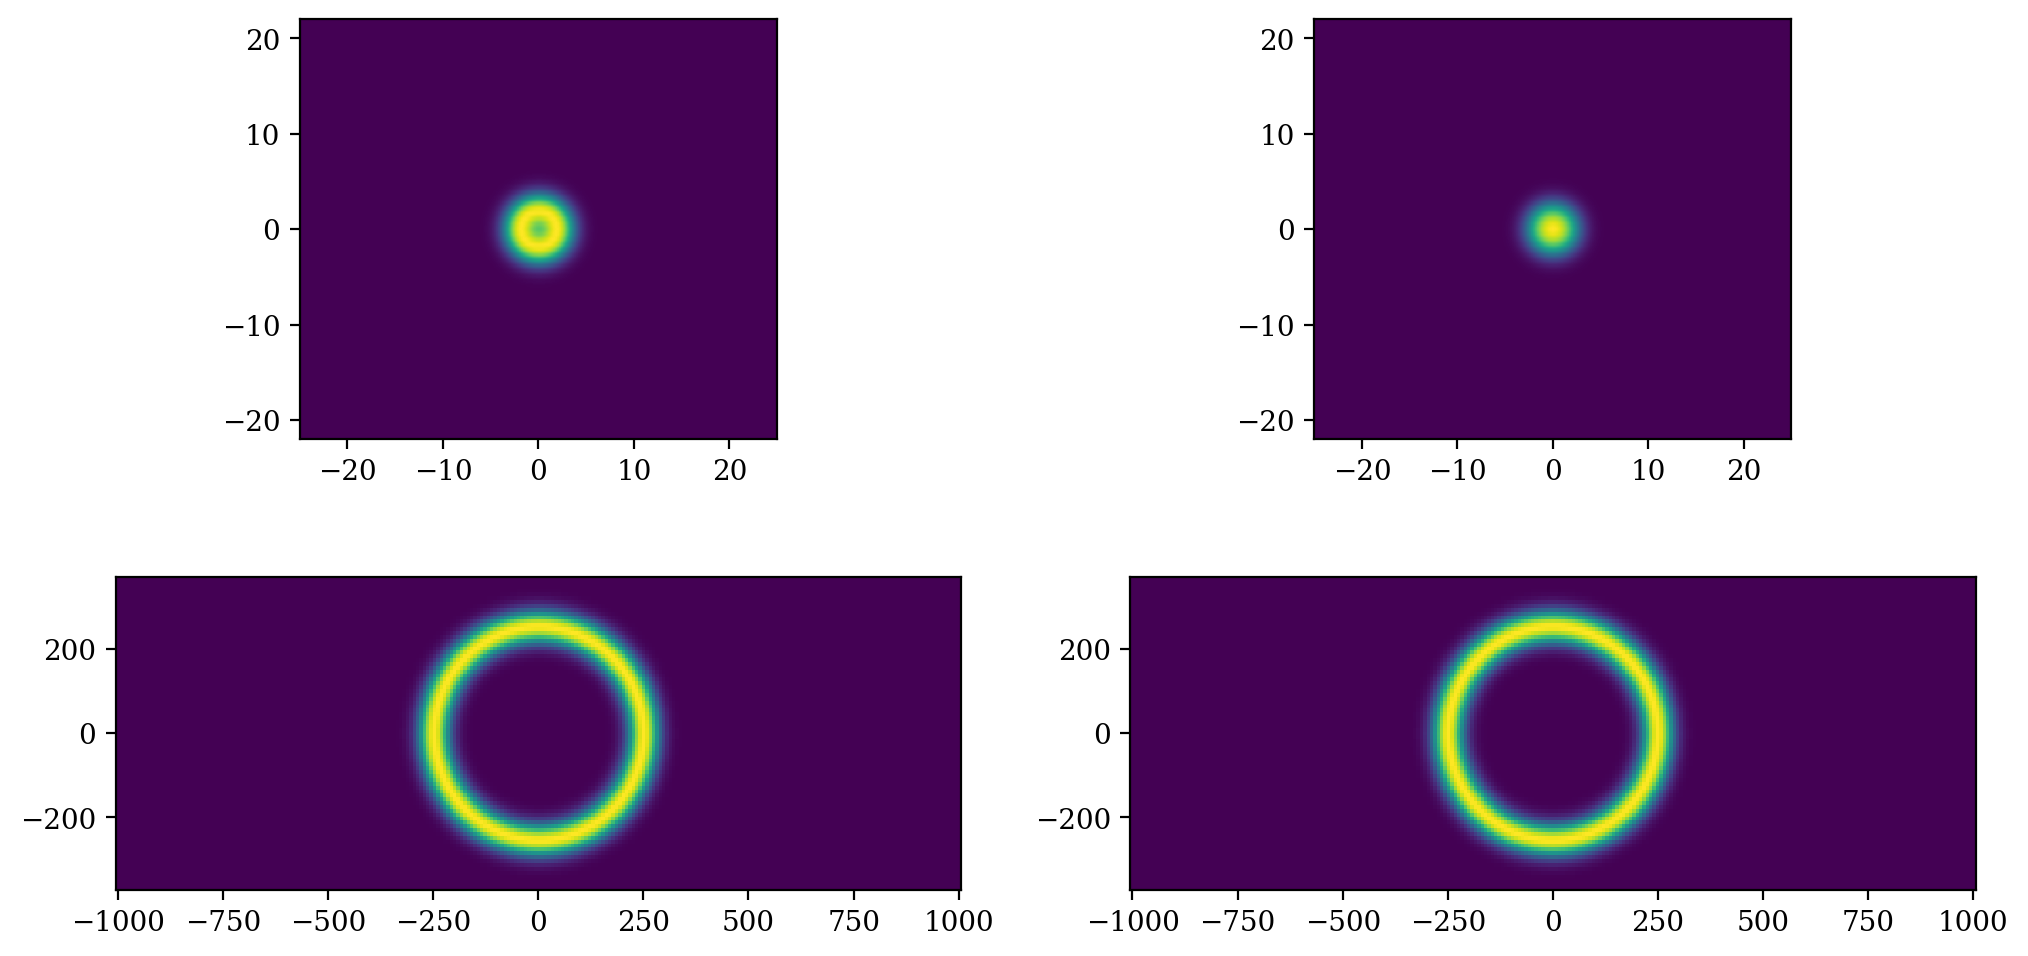

13633.487MB of system memory used


In [55]:
print("check normalisation psi", check_norm(psi))
phi, swnf = phiAndSWNF(psi)
print("check normalisation phi", check_norm_phi(phi))
print("swnf =", swnf)

plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,2)
plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax,zmax])

plt.subplot(2,2,3)
plt.imshow(np.flipud(only3phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(np.flipud(only4phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])
# plt.colorbar()

plt.show()
current_py_memory_print()

Notes on parameters

`psi = psi0ring(dr=40,s3=2,s4=2,pt=p,an=32,logging=True)` took fucking 15 minutes to generate but it looks pretty smooth

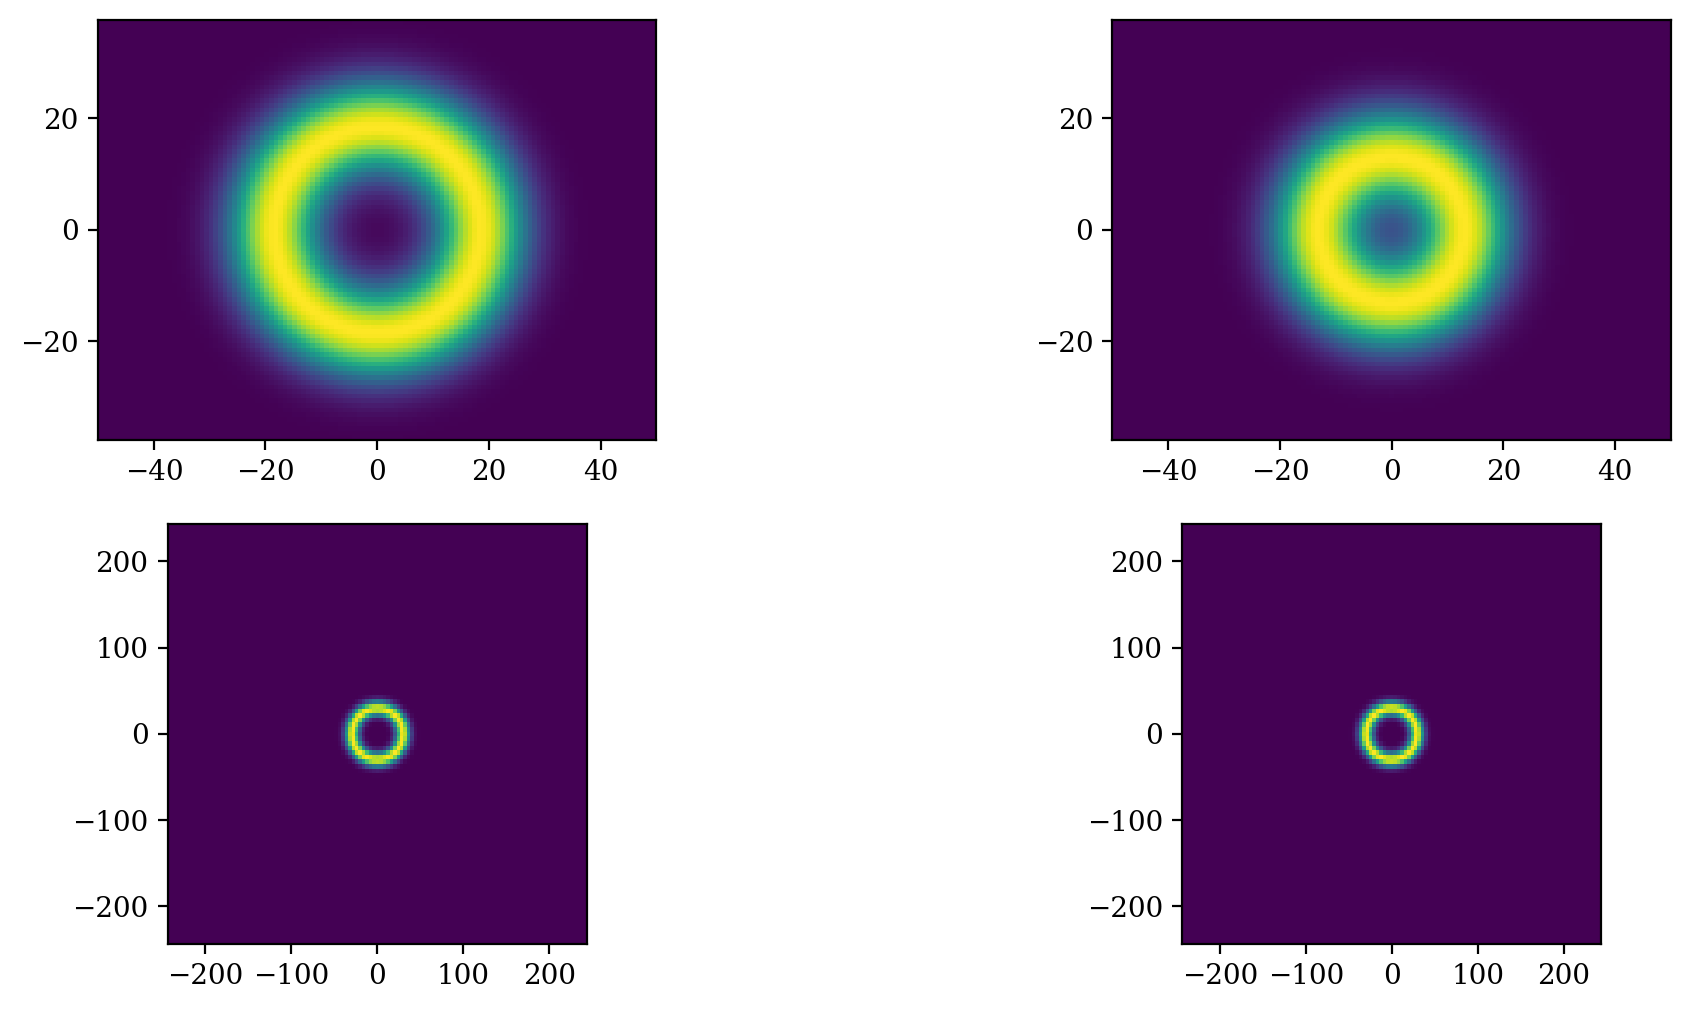

`psi = psi0ring_with_logging(dr=40,s3=3,s4=3,pt=2*hb*k,an=32)`
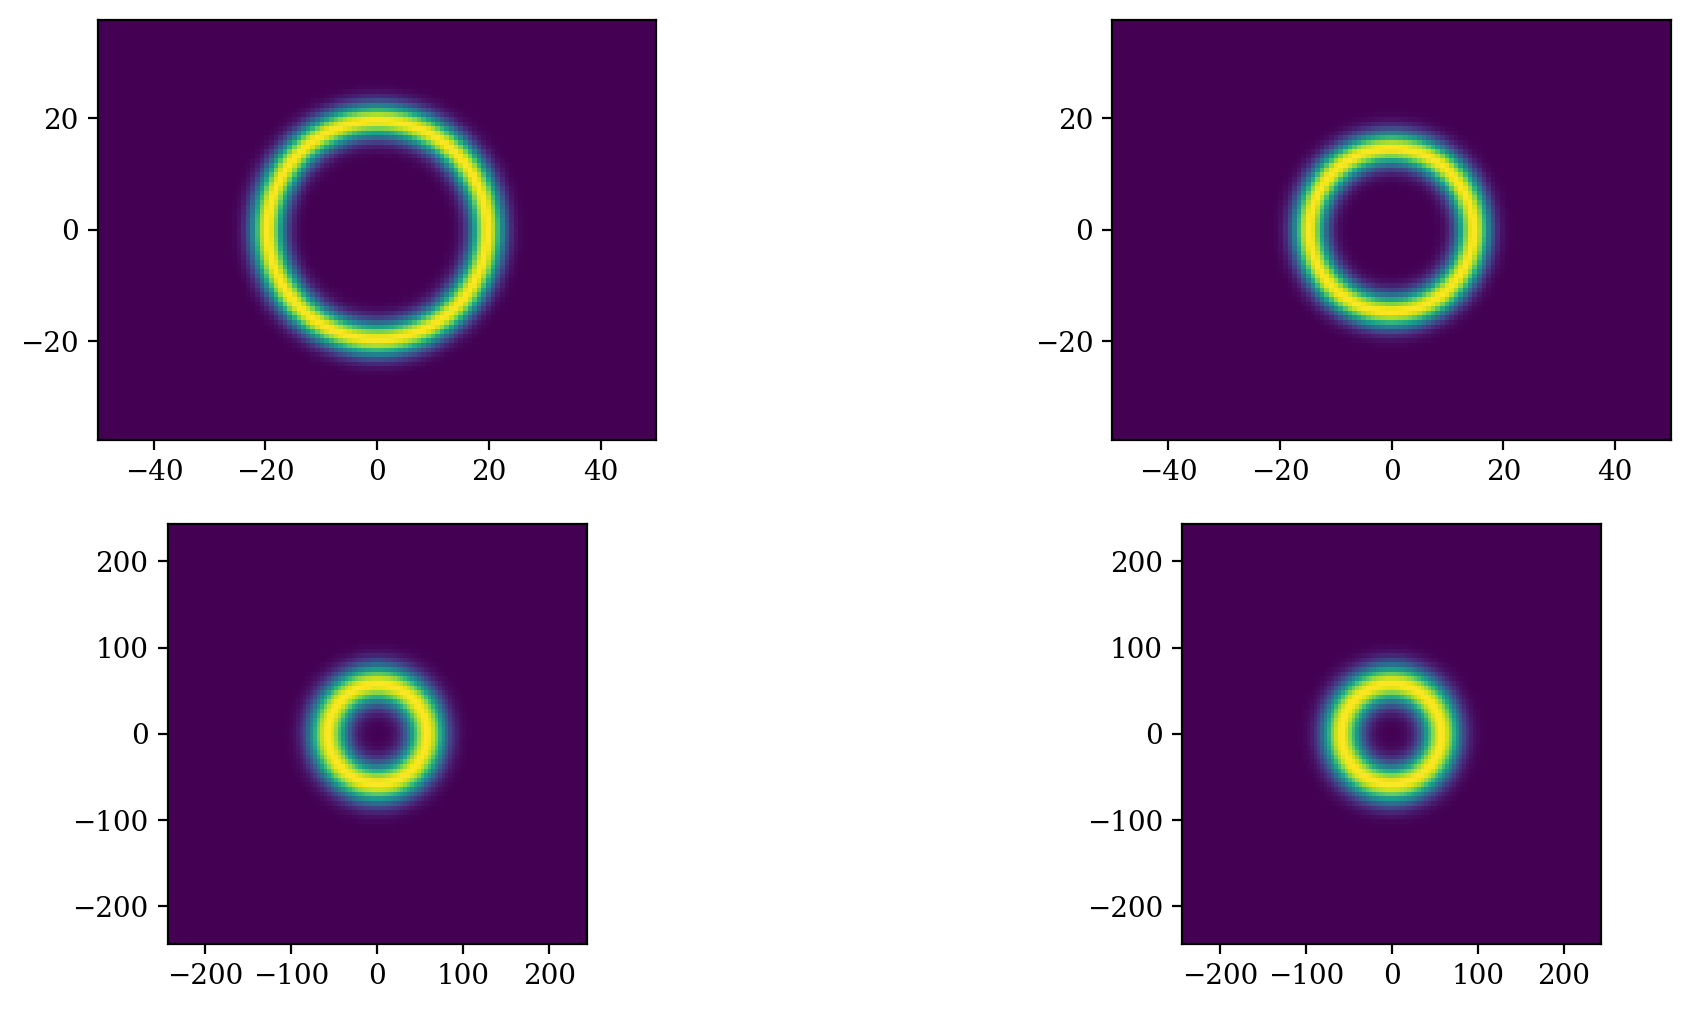

In [106]:
((nx-1)/2, (nz-1)/2)

(60.0, 45.0)

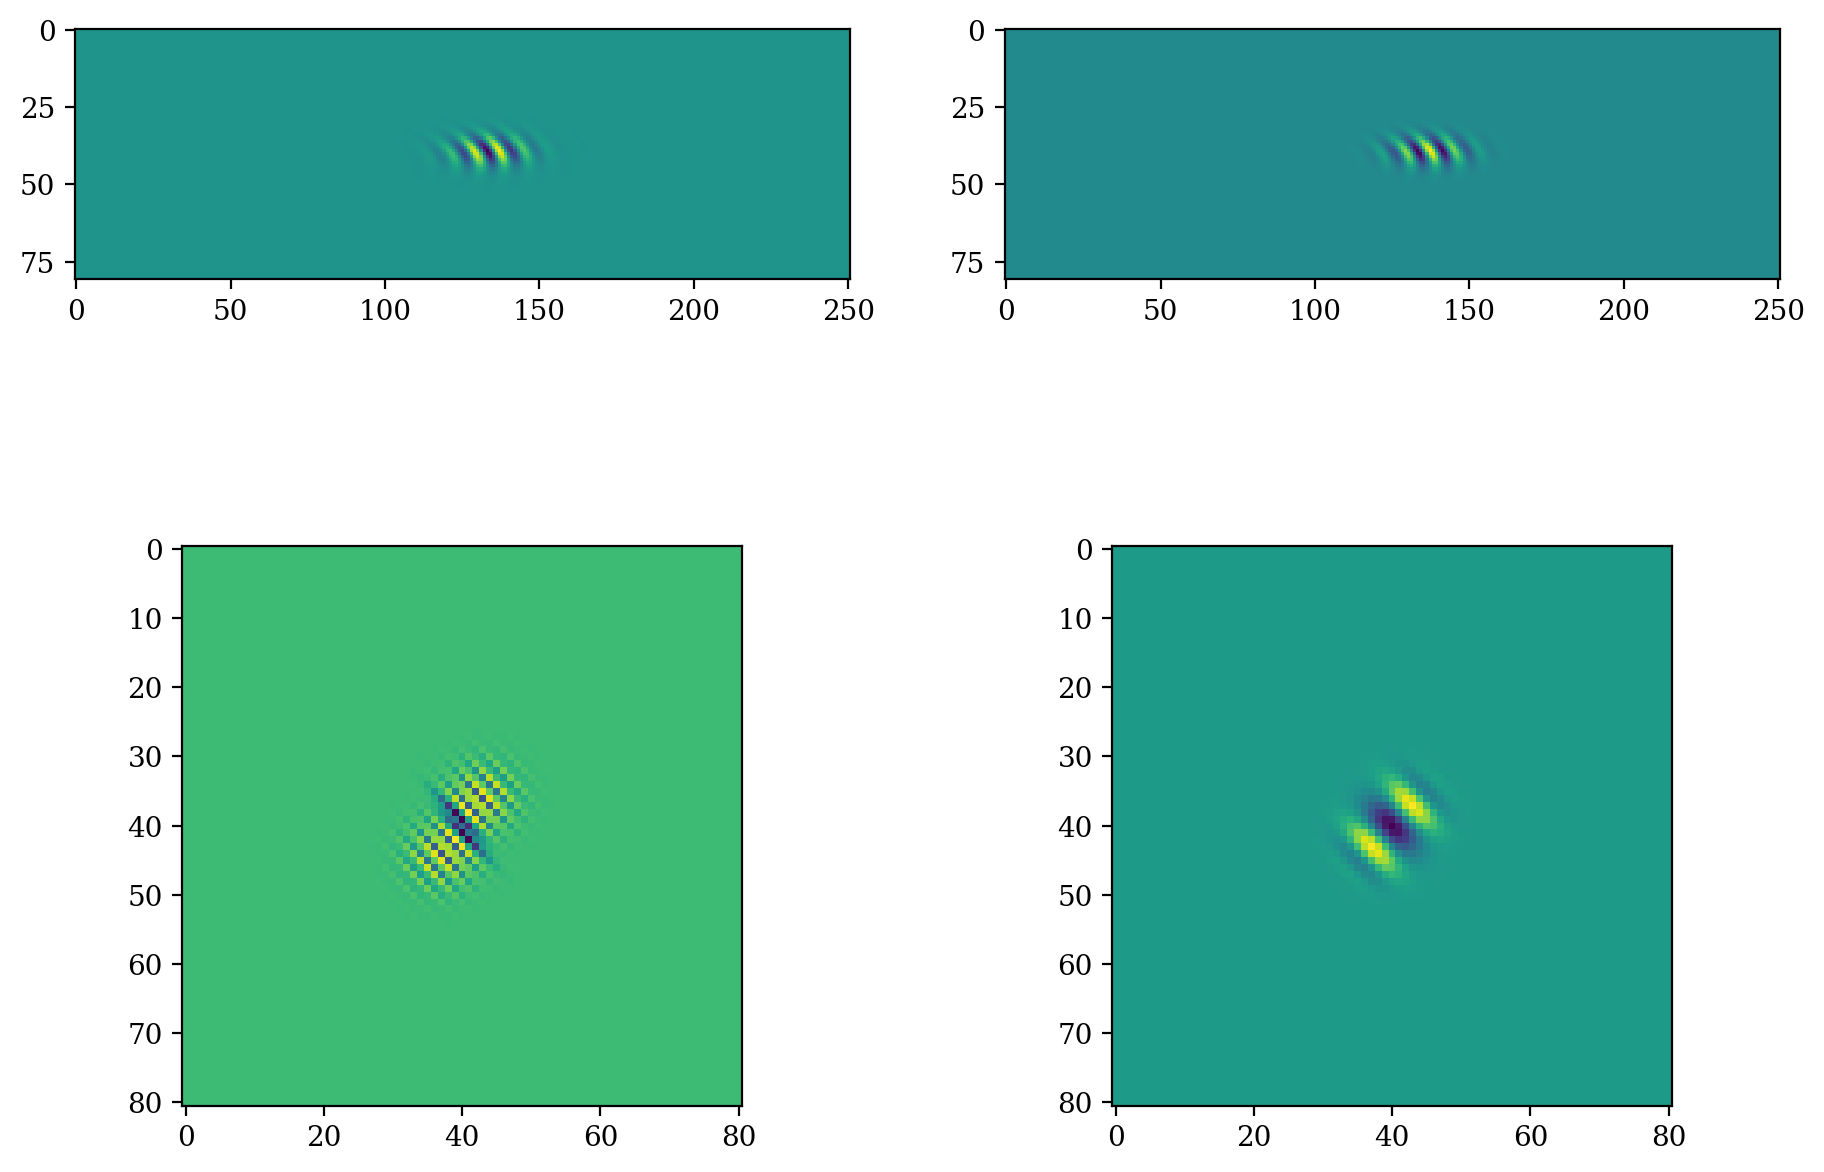

In [57]:
plt.figure(figsize=(11,8))
plt.subplot(2,2,1)
plt.imshow(np.real(psi[60,:,:,45]))
plt.subplot(2,2,2)
plt.imshow(np.real(psi[:,45,60,:].T))
plt.subplot(2,2,3)
plt.imshow(np.real(psi[60,:,60,:]))
plt.subplot(2,2,4)
plt.imshow(np.real(psi[30,:,90,:]))

no idea what those mean...

## Correlation Function

In [34]:
def gx3x4_calc(psi,cut=5.0):
    ind = abs(zlin) < (cut+1e-15)*dz
    gx3x4 = np.trapz(np.abs(psi[:,:,:,ind])**2,zlin[ind],axis=3)
    gx3x4 = np.trapz(gx3x4[:,ind,:],zlin[ind],axis=1)
    return gx3x4

In [35]:
def plot_gx3x4(gx3x4,cut):
    xip = xlin > 0
    xim = xlin < 0
    gpp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xip],xlin[xip],axis=0)
    gpm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xip],xlin[xip],axis=0)
    gmp = np.trapz(np.trapz(gx3x4[:,xip],xlin[xip],axis=1)[xim],xlin[xim],axis=0)
    gmm = np.trapz(np.trapz(gx3x4[:,xim],xlin[xim],axis=1)[xim],xlin[xim],axis=0)
    E = (gpp+gmm-gpm-gmp)/((gpp+gmm+gpm+gmp))
    
    plt.imshow(np.flipud(gx3x4.T),extent=[-xmax,xmax,-xmax,xmax])
    plt.title("$g^{(2)}_{\pm\pm}$ of $z_\mathrm{cut} = "+str(cut)+"dz$ and $E="+str(round(E,4))+"$")
    plt.xlabel("$x_3$")
    plt.ylabel("$x_4$")
    plt.axhline(y=0,color='white',alpha=0.8,linewidth=0.7)
    plt.axvline(x=0,color='white',alpha=0.8,linewidth=0.7)
    plt.text(+xmax*0.6,+xmax*0.8,"$g^{(2)}_{++}="+str(round(gpp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,+xmax*0.8,"$g^{(2)}_{-+}="+str(round(gmp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(+xmax*0.6,-xmax*0.8,"$g^{(2)}_{+-}="+str(round(gpm,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,-xmax*0.8,"$g^{(2)}_{--}="+str(round(gmm,4))+"$", color='white',ha='center',alpha=0.9)
    

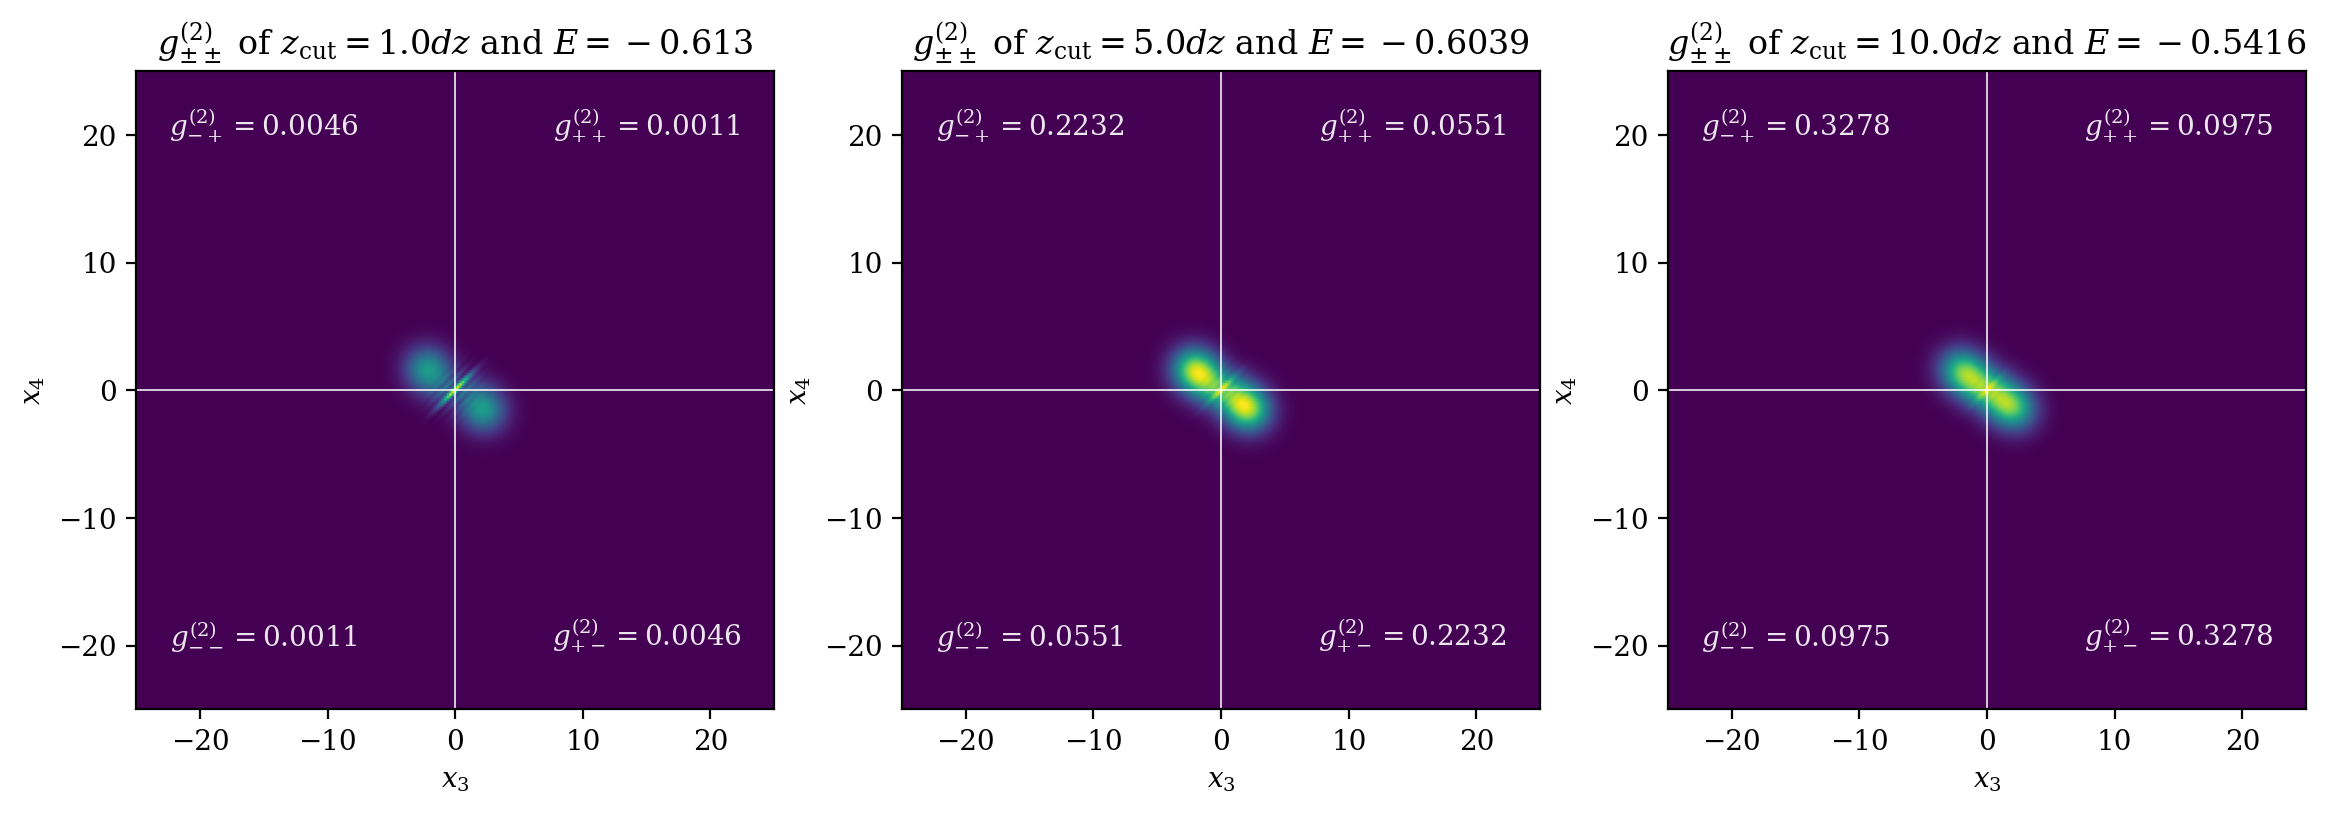

In [51]:
plt.figure(figsize=(14,6))

cut_list = [1.0, 5.0, 10.0]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()

 eq on p.73 GoodNotes document
 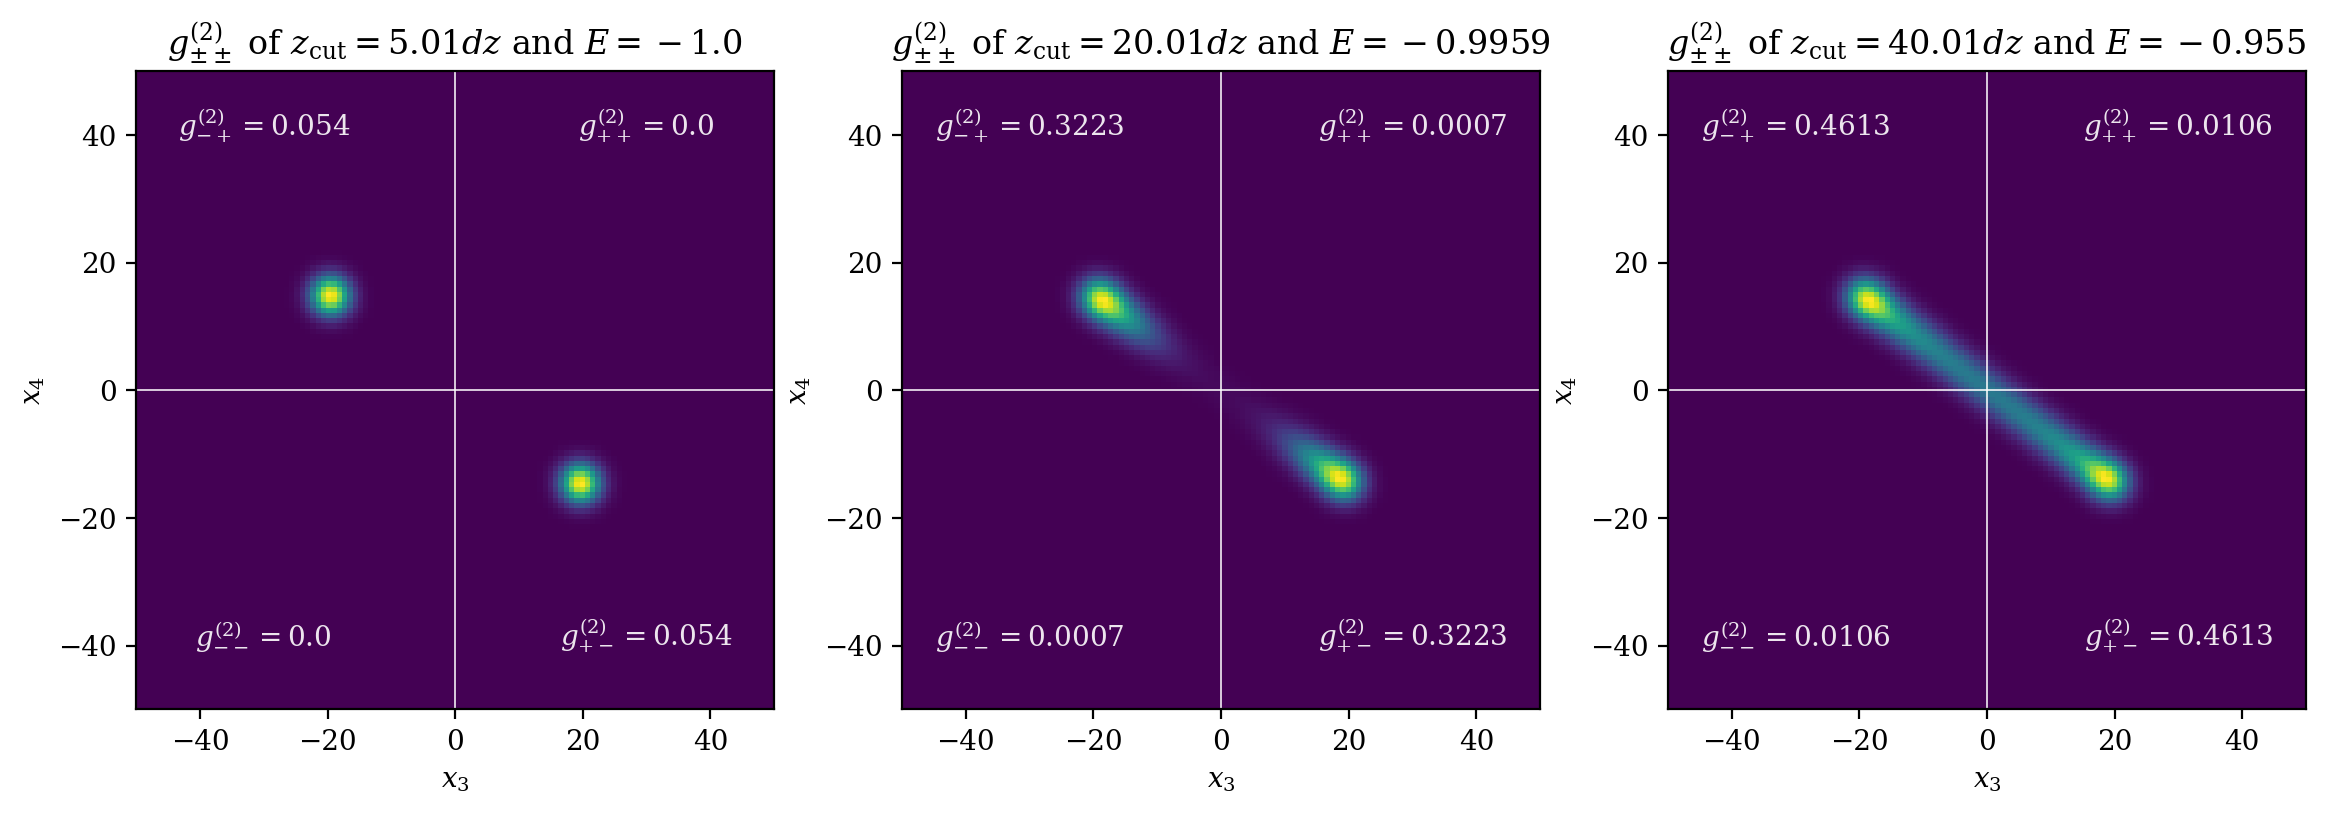

In [34]:
del gx3x4

NameError: name 'gx3x4' is not defined

## FFT to momentum

In [36]:
@jit(forceobj=True, cache=True)
def only3phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2)
#     return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=2),dx=dpz,axis=2)
@jit(forceobj=True, cache=True)
def only4phi(phi):
    return np.trapz(np.trapz(np.abs(phi)**2,dx=dpx,axis=0),dx=dpz,axis=0)

@njit(cache=True)
def check_norm_phi(phi):
#     return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2,dx=dpz,axis=3),dx=dpx,axis=2),dx=dpz,axis=1),dx=dpx,axis=0)
    return np.trapz(np.trapz(np.trapz(np.trapz(np.abs(phi)**2))))*(dpx*dpx*dpz*dpz)



In [37]:
@jit(forceobj=True, cache=True)
def phiAndSWNF(psi, nthreads=nthreads):
    phiUN = np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)
    superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
    swnf = sqrt(superWeirdNormalisationFactorSq)
    phi = phiUN/swnf
    return phi, (swnf+0*1j)

@jit(forceobj=True, cache=True)
def toPhi(psi, swnf, nthreads=nthreads) -> np.ndarray:
    return np.flip(np.flip(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fftn(psi,threads=nthreads,norm='ortho')),axis=1),axis=3)/swnf

@jit(forceobj=True, cache=True)
def toPsi(phi, swnf, nthreads=nthreads) -> np.ndarray:
    return pyfftw.interfaces.numpy_fft.ifftn(np.fft.ifftshift(np.flip(np.flip(phi*swnf,axis=3),axis=1)),threads=nthreads,norm='ortho')




In [33]:
# # @njit(parallel=True,cache=True)
# @jit
# def phiAndSWNF(psi):
#     phiUN = np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)
#     superWeirdNormalisationFactorSq = check_norm_phi(phiUN)
#     swnf = sqrt(superWeirdNormalisationFactorSq)
#     phi = phiUN/swnf
#     return phi, swnf

# @njit(parallel=True,cache=True)
# def toPhi(psi, swnf):
#     return np.flip(np.flip(np.fft.fftshift(np.fft.fftn(psi,norm='ortho')),axis=1),axis=3)/swnf

# @njit(parallel=True,cache=True)
# def toPsi(phi, swnf):
#     return np.fft.ifftn(np.fft.ifftshift(np.fliplr(phi*swnf)),norm='ortho')

In [56]:
del t, psi, phi, swnf

NameError: name 't' is not defined

## Scattering via contact potential ?

In [34]:
3*hb*k/m3

299.2734568884748

In [35]:
20/249/dt

160.6425702811245

In [47]:
# del psi_test

In [62]:
numba.set_num_threads(7)
# Each thread will multiply the memory usage!
# e.g. single thread 20GB -> 2 threads ~30GB

In [63]:
# a34 = 0.029 #µm
a34 = 0.5 #µm
strength34 = 1e5 # I don't know

In [64]:
-(1j/hb) * strength34 * np.exp(-((0-0)**2 +(0-0)**2)/(4*a34**2)) *0.5*dt

-0.3936524332444204j

## Scattering? 

In [65]:
# @njit(parallel=True,cache=True)
@njit
def scattering_evolve_loop_helper2_inner_psi_step(psi_init):
    psi = psi_init
    for iz3 in prange(nz):
        z3 = zlin[iz3]
#     for (iz3, z3) in enumerate(zlin):
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] *= np.exp(-(1j/hb) * # this one is unitary time evolution operator
                                        strength34 *
                                        np.exp(-((xlin-x4)**2 +(z3-z4)**2)/(4*a34**2))
                                               # inside the guassian contact potential
                                               *0.5*dt
                                            )
    return psi

# @njit(parallel=True,cache=True)
@njit
def scattering_evolve_loop_helper2_inner_phi_step(phi_init):
    phi = phi_init
    for iz3 in prange(nz):
        pz3 = pzlin[iz3]
#     for (iz3, pz3) in enumerate(pzlin):
        for (ix4, px4) in enumerate(pxlin):
            for (iz4, pz4) in enumerate(pzlin):
                phi[:,iz3,ix4,iz4] *= np.exp(-(1j/hb) * (0.5/m3) * (dt) * (pxlin**2 + pz3**2) \
                                               -(1j/hb) * (0.5/m4) * (dt) * (  px4**2 + pz4**2))
    return phi

# @jit(nogil=True, parallel=True, forceobj=True)
@jit(nogil=True, forceobj=True)
# @njit(nogil=True, parallel=True)
def scattering_evolve_loop_helper2(t_init, psi_init, swnf, steps=20, progress_proxy=None):
    t = t_init
    psi = psi_init
    for ia in prange(steps):
        
        psi = scattering_evolve_loop_helper2_inner_psi_step(psi)
#         phi = np.zeros_like(psi, dtype=dtype)
#         with objmode(phi='complex128[:,:,:,:]'):
        phi = toPhi(psi, swnf, nthreads=7)
        phi = scattering_evolve_loop_helper2_inner_phi_step(phi)
        #del psi 
        # might cause memory issues
#         psi2 = np.zeros_like(phi, dtype=dtype)
#         with objmode(psi2='complex128[:,:,:,:]'):
        psi = toPsi(phi, swnf, nthreads=7)
#         psi = psi2
        psi = scattering_evolve_loop_helper2_inner_psi_step(psi)
        t += dt 
        if progress_proxy != None:
            progress_proxy.update(1)                                   
    return (t, psi, phi)

In [66]:
gc.collect()
su = 1.7
se = 15
print("want to stop at t =", (0.5*se+5)/v3)
print("number of steps is ", (0.5*se+5)/v3/dt)

print_every = 4
frames_count = 60
total_steps = print_every * frames_count
print("Total steps =" ,total_steps)

want to stop at t = 0.1253034612220037
number of steps is  250.60692244400738
Total steps = 240


In [67]:
total_steps*dt 

0.12

In [68]:
@njit(parallel=True, cache=True)
def psi0_just_opposite_double(dr=20,s3=sg,s4=sg,pt=0,a=0,xlin=xlin,zlin=zlin,fuck3=0):
    dr3 = 0.5 * dr;
    dr4 = 0.5 * (m3/m4) * dr;
    dx3 = dr3 * cos(a)
    dz3 = dr3 * sin(a)
    dx4 = dr4 * cos(a)
    dz4 = dr4 * sin(a)
    ph = 0.5 * pt;
    px = +ph * cos(a)
    pz = +ph * sin(a)
    
    dx3m = dr3 * cos(-a)
    dz3m = dr3 * sin(-a)
    dx4m = dr4 * cos(-a)
    dz4m = dr4 * sin(-a)
    pxm = +ph * cos(-a)
    pzm = +ph * sin(-a)
    
#     print((+px,+pz,-px,-pz))
#     psi = psi0_just_opposite_loop_helper(dx3,dz3,dx4,dz4,s3,s4,px,pz,xlin,zlin)
    psi = np.zeros((nx,nz,nx,nz),dtype=dtype)
#     for (iz3, z3) in enumerate(zlin):
    for iz3 in prange(nz):
        z3 = zlin[iz3]
        for (ix4, x4) in enumerate(xlin):
            for (iz4, z4) in enumerate(zlin):
                psi[:,iz3,ix4,iz4] = \
                psi0gaussianNN(
                    xlin-dx3,z3-dz3, x4+dx4,z4+dz4, s3,s3, s4,s4,+fuck3*px,+fuck3*pz,-px,-pz) #+ \
#                 psi0gaussianNN( #AHHH THIS IS SHITTY SINGLE USE CODE
#                     xlin-dx3m,z3-dz3m, x4+dx4m,z4+dz4m, s3,s3, s4,s4,+fuck3*pxm,+fuck3*pzm,-pxm,-pzm)
    normalisation = check_norm(psi)
    return (psi/sqrt(normalisation)).astype(dtype)

In [69]:
# psi = psi0_just_opposite(dr=0,s3=su,s4=su,pt=-2.5*hb*k,a=0.5*pi)
# psi = psi0_just_opposite(dr=0,s3=su,s4=su,pt=-2*hb*k,a=+0.5*pi) + \
#       psi0_just_opposite(dr=0,s3=su,s4=su,pt=-2*hb*k,a=-0.5*pi) 
# normalisation = check_norm(psi)
# psi = (psi/sqrt(normalisation)).astype(dtype)
psi = psi0_just_opposite_double(dr=0,s3=su*1.2,s4=su,pt=-2.5*hb*k,a=0.5*pi)

t = 0
f = 0
phi, swnf = phiAndSWNF(psi, nthreads=7)

tested on A2485
```
%timeit _ = phiAndSWNF(psi,nthreads=1)
28.2 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=2)
21.1 s ± 352 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=3)
18.8 s ± 827 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=4)
17.2 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=5)
16.6 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=6)
12.9 s ± 1.51 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=7)
11.9 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

%timeit _ = phiAndSWNF(psi,nthreads=8)
11.8 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

```

In [70]:
def scattering_evolve_loop_plot(t,f,psi,phi, plt_show=True, plt_save=False):
    t_str = str(round(t,5))
    if plt_show:
        print("t = " +t_str+ " \t\t frame =", f, "\t\t memory used: " + 
              str(round(current_py_memory()/1000**2,3)) + "MB  ")

    fig = plt.figure(figsize=(12,7))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax],cmap='Reds')
#     plt.imshow(np.log(np.flipud(only3(psi).T)), extent=[-xmax,xmax,-zmax, zmax],cmap='Reds')
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")
    plt.title("$t="+t_str+" \ ms $")

    plt.subplot(2,2,2)
    plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax],cmap='Blues')
#     plt.imshow(np.log(np.flipud(only4(psi).T)), extent=[-xmax,xmax,-zmax, zmax],cmap='Blues')
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")

    plt.subplot(2,2,3)
    plt.imshow((only3phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Reds')
#     plt.imshow(np.log(only3phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Reds')
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$p_z \ (\hbar k)$")

    plt.subplot(2,2,4)
    plt.imshow((only4phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Blues')
#     plt.imshow(np.log(only4phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Blues')
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.xlabel("$p_x \ (\hbar k)$")

    if plt_save:
        title= output_prefix_bracket + " scattering_evolve_loop_plot (f="+str(f)+",t="+t_str+")" 
        plt.savefig("output/"+title+".pdf", dpi=600)
        plt.savefig("output/"+title+".png", dpi=600)
    
    if plt_show: plt.show() 
    else:        plt.close(fig) 

t = 0 		 frame = 0 		 memory used: 11082.056MB  


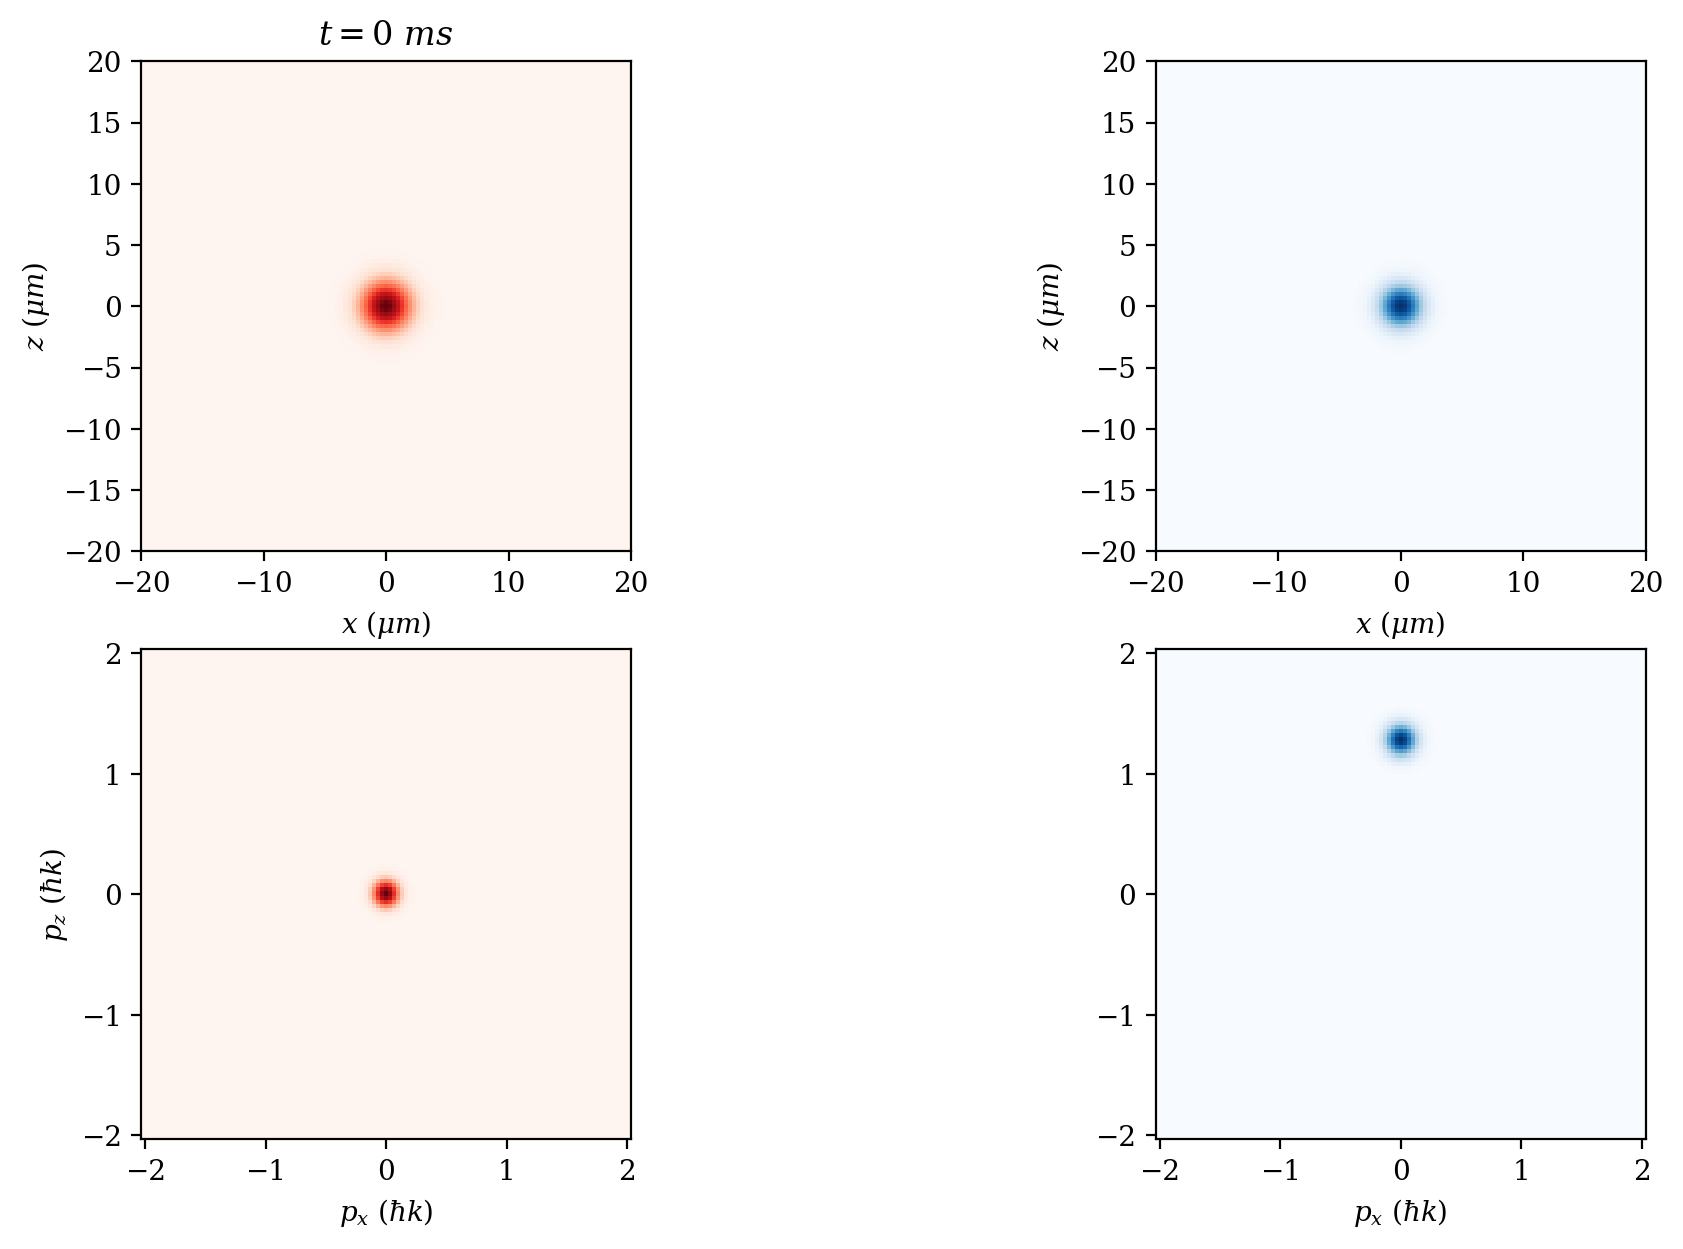

In [71]:
scattering_evolve_loop_plot(t,f,psi,phi, plt_show=True, plt_save=False)

In [72]:
gc.collect()

12594

In [45]:
_ = scattering_evolve_loop_helper2(t,psi,swnf,steps=print_every,progress_proxy=None)

  0%|                                                                                                         …

t = 0.12 		 frame = 60 		 memory used: 9848.947MB  


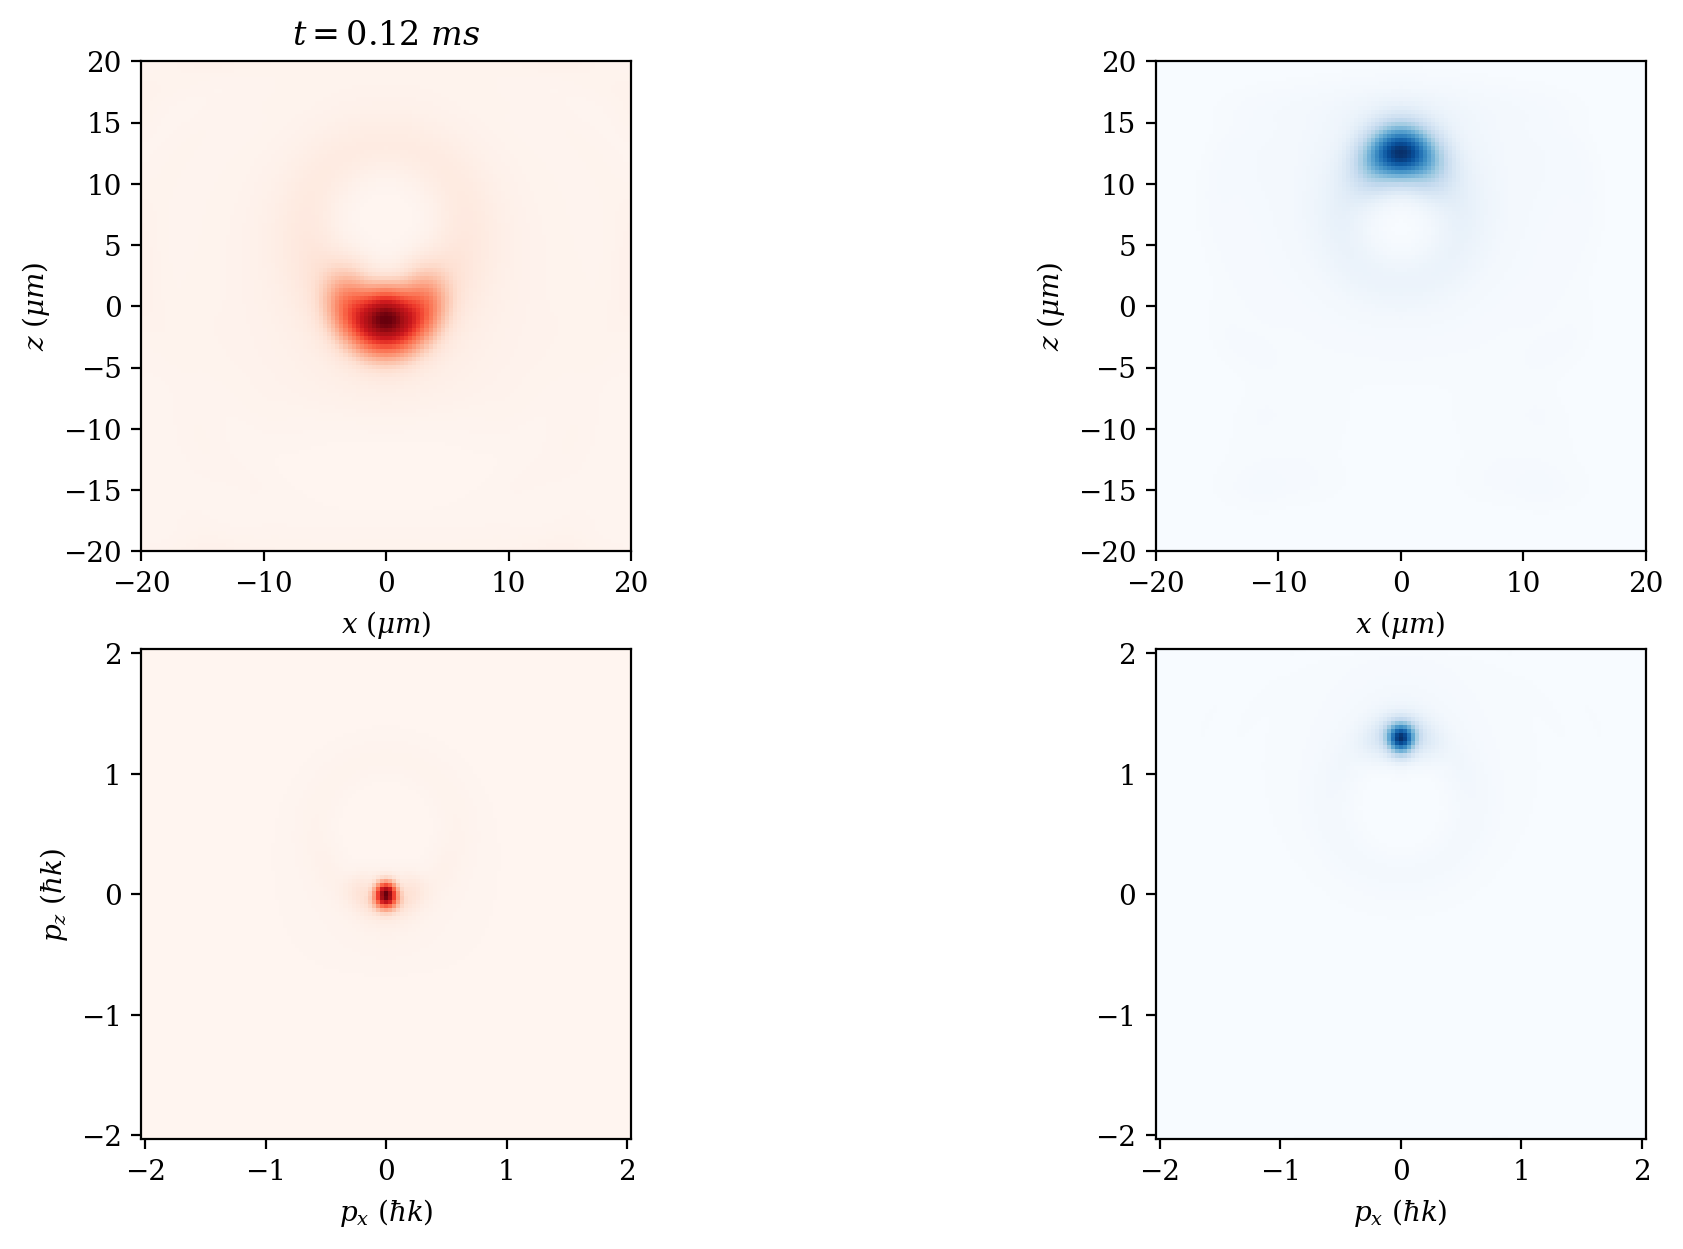

In [73]:
with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot(t,f,psi,phi, plt_show=False, plt_save=True)
        gc.collect()
        (t,psi,phi) = scattering_evolve_loop_helper2(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot(t,f+1,psi,phi, plt_show=True, plt_save=True)

In [74]:
def scattering_evolve_loop_plot_alt(t,f,psi,phi, plt_show=True, plt_save=False, power=1):
    t_str = str(round(t,5))
    if plt_show:
        print("t = " +t_str+ " \t\t frame =", f, "\t\t memory used: " + 
              str(round(current_py_memory()/1000**2,3)) + "MB  ")

    fig = plt.figure(figsize=(12,7))
    plt.subplot(2,2,1)
#     plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax],cmap='Reds')
#     plt.imshow(np.emath.logn(power,np.flipud(only3(psi).T)), extent=[-xmax,xmax,-zmax, zmax],cmap='Reds')
    plt.imshow(np.power(np.flipud(only3(psi).T),power), extent=[-xmax,xmax,-zmax, zmax],cmap='Reds')
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")
    plt.title("$t="+t_str+" \ ms $")

    plt.subplot(2,2,2)
#     plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax],cmap='Blues')
    plt.imshow(np.power(np.flipud(only4(psi).T),power), extent=[-xmax,xmax,-zmax, zmax],cmap='Blues')
#     plt.imshow(np.emath.logn(power,np.flipud(only4(psi).T)), extent=[-xmax,xmax,-zmax, zmax],cmap='Blues')
    plt.xlabel("$x \ (\mu m)$")
    plt.ylabel("$z \ (\mu m)$")

    plt.subplot(2,2,3)
#     plt.imshow((only3phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Reds')
    plt.imshow(np.power(only3phi(phi).T,power), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Reds')
#     plt.imshow(np.emath.logn(power,only3phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Reds')
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.ylabel("$p_z \ (\hbar k)$")

    plt.subplot(2,2,4)
#     plt.imshow((only4phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Blues')
    plt.imshow(np.power(only4phi(phi).T,power), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Blues')
#     plt.imshow(np.emath.logn(power,only4phi(phi).T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k),cmap='Blues')
    # plt.colorbar()
    plt.xlabel("$p_x \ (\hbar k)$")
    plt.xlabel("$p_x \ (\hbar k)$")

    if plt_save:
        title= output_prefix_bracket + " scattering_evolve_loop_plot alt (f="+str(f)+",t="+t_str+",power="+str(power)+")" 
        plt.savefig("output/"+title+".pdf", dpi=600)
        plt.savefig("output/"+title+".png", dpi=600)
    
    if plt_show: plt.show() 
    else:        plt.close(fig) 

t = 0.12 		 frame = 59 		 memory used: 9986.163MB  


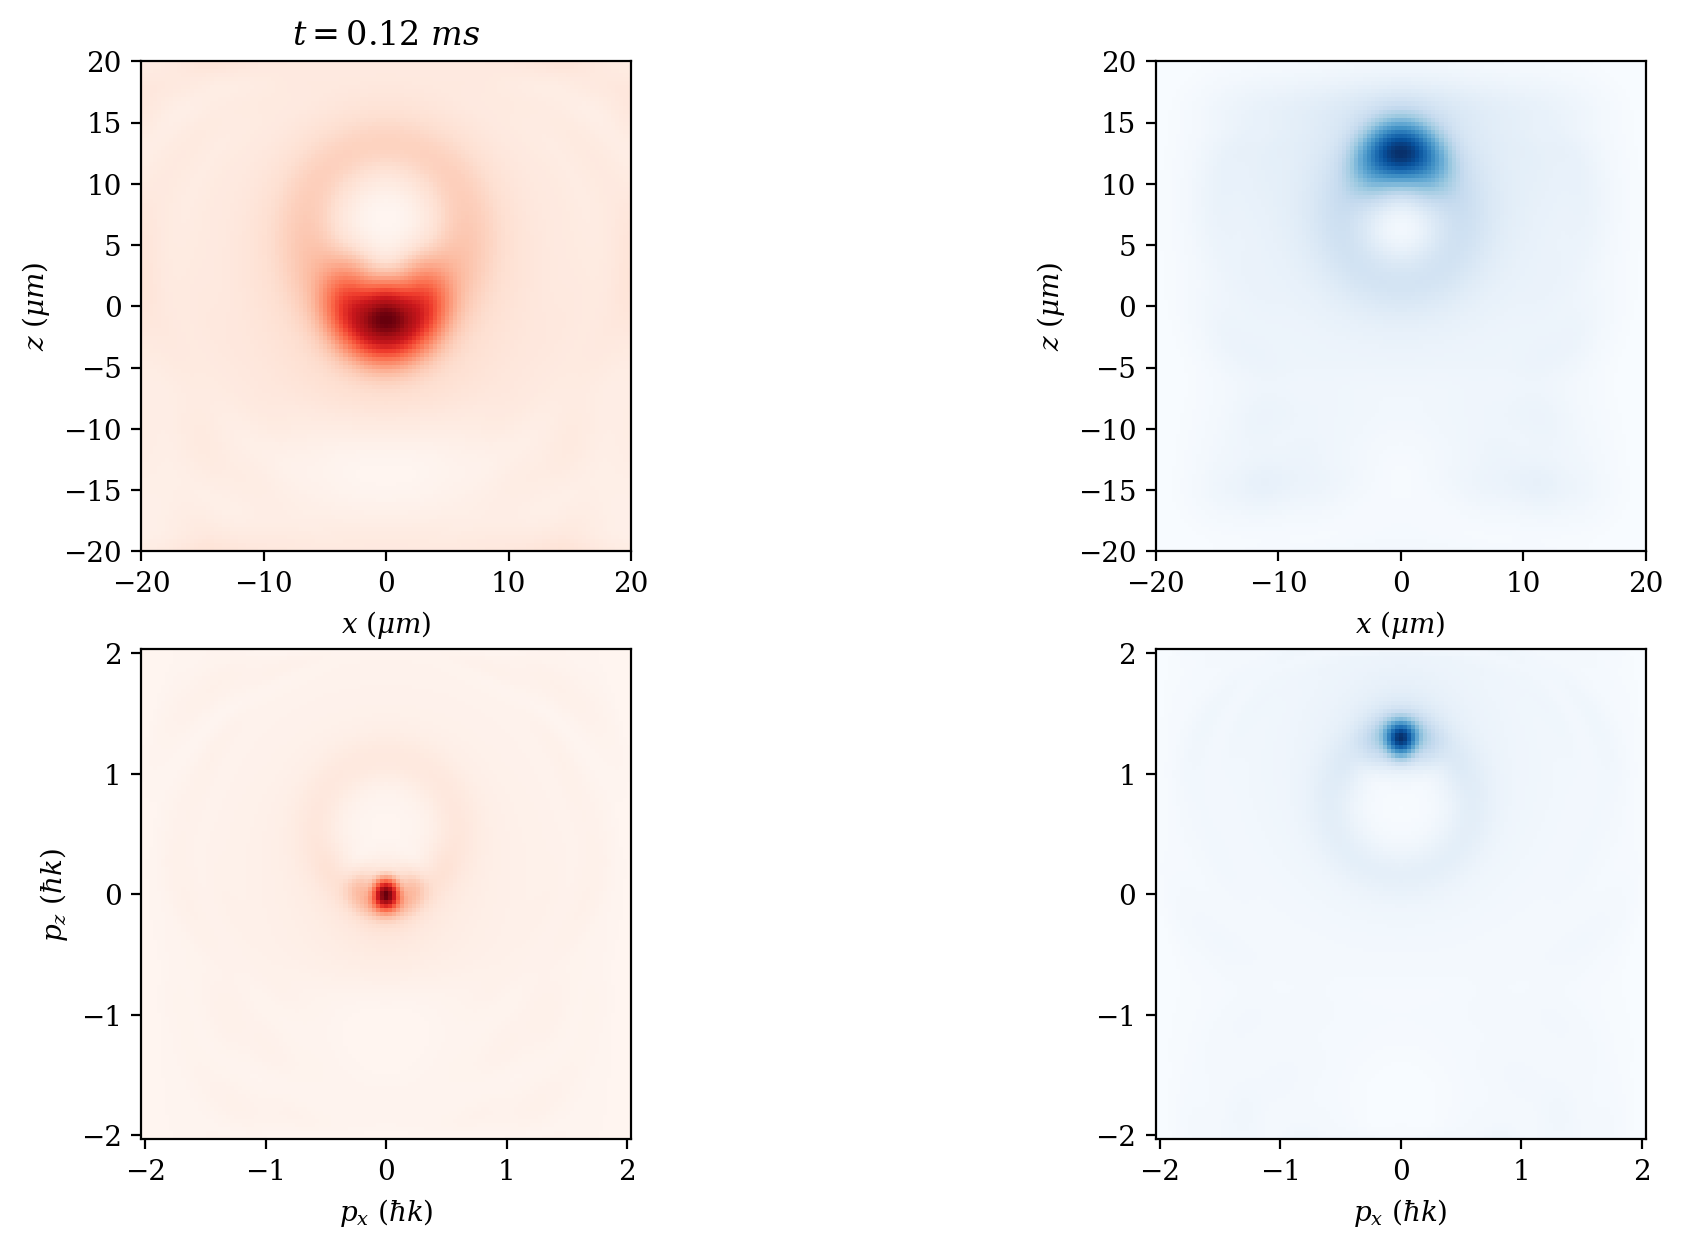

In [76]:
scattering_evolve_loop_plot_alt(t,f,psi,phi, plt_show=True, plt_save=True, power=0.6)

In [112]:
ptt=2.5*hb*k*0.5
pthk = 2.5*0.5
print(ptt,pthk)

374.09182111059346 1.25


In [119]:
dpz

9.975781896282493

In [77]:
def gp3p4_dhalo_calc(phi,cut=5.0,offset3=0,offset4=0):
    ind3 = abs(pzlin-offset3) < (cut+1e-15)*dpz
    ind4 = abs(pzlin-offset4) < (cut+1e-15)*dpz
    gx3x4 = np.trapz(np.abs(phi[:,:,:,ind3])**2,pzlin[ind3],axis=3)
    gx3x4 = np.trapz(gx3x4[:,ind4,:],pzlin[ind4],axis=1)
    return gx3x4 

In [78]:
def plot_dhalo_gp3p4(gx3x4,cut,offset3=0,offset4=0):
    xip = pxlin > +0*cut*dpz 
    xim = pxlin < -0*cut*dpz 
    gpp = np.trapz(np.trapz(gx3x4[:,xip],pxlin[xip],axis=1)[xip],pxlin[xip],axis=0)
    gpm = np.trapz(np.trapz(gx3x4[:,xim],pxlin[xim],axis=1)[xip],pxlin[xip],axis=0)
    gmp = np.trapz(np.trapz(gx3x4[:,xip],pxlin[xip],axis=1)[xim],pxlin[xim],axis=0)
    gmm = np.trapz(np.trapz(gx3x4[:,xim],pxlin[xim],axis=1)[xim],pxlin[xim],axis=0)
    E = (gpp+gmm-gpm-gmp)/((gpp+gmm+gpm+gmp))
    
    plt.imshow(np.flipud(gx3x4.T), extent=np.array([-pxmax,pxmax,-pzmax,pzmax])/(hb*k))
    plt.title("$g^{(2)}_{\pm\pm}$ of $p_\mathrm{cut} = "+str(cut)+"dpz$ and $E="+str(round(E,4))+"$")
    plt.xlabel("$p_3$")
    plt.ylabel("$p_4$")
    plt.axhline(y=0,color='white',alpha=0.8,linewidth=0.7)
    plt.axvline(x=0,color='white',alpha=0.8,linewidth=0.7)
    plt.text(+xmax*0.6,+xmax*0.8,"$g^{(2)}_{++}="+str(round(gpp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,+xmax*0.8,"$g^{(2)}_{-+}="+str(round(gmp,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(+xmax*0.6,-xmax*0.8,"$g^{(2)}_{+-}="+str(round(gpm,4))+"$", color='white',ha='center',alpha=0.9)
    plt.text(-xmax*0.6,-xmax*0.8,"$g^{(2)}_{--}="+str(round(gmm,4))+"$", color='white',ha='center',alpha=0.9)
    

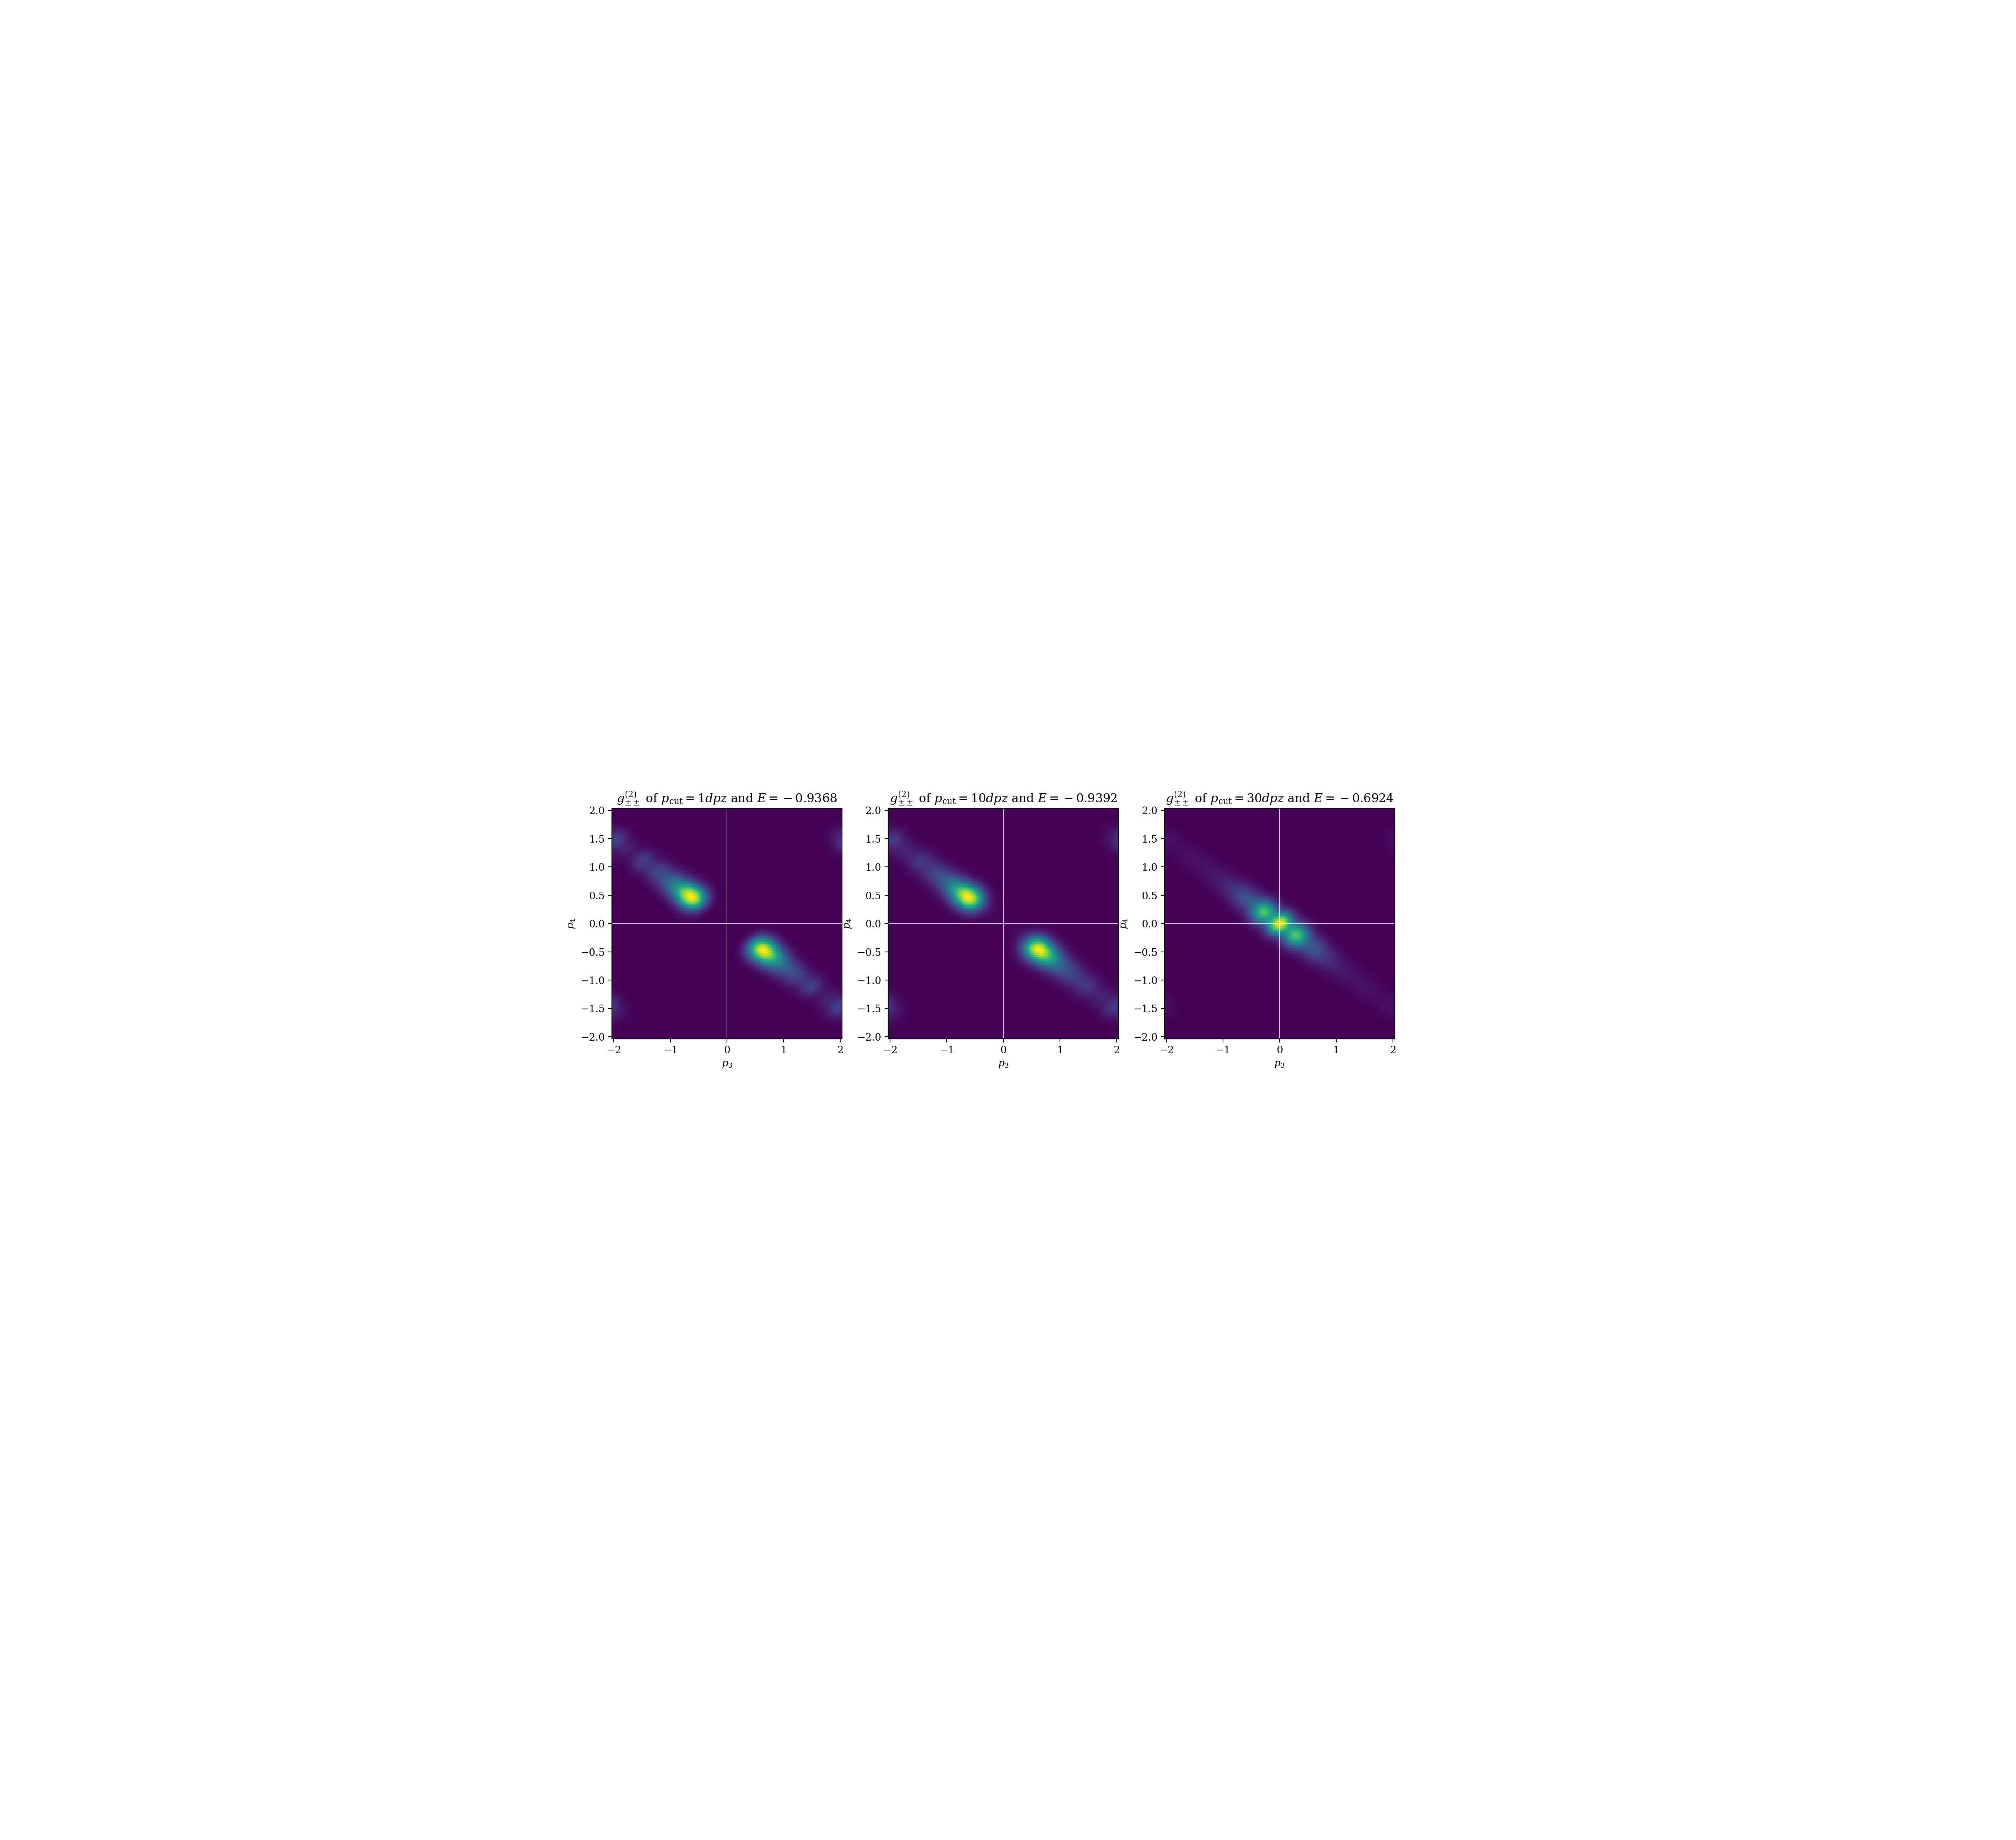

In [79]:
plt.figure(figsize=(14,6))

cut_list = [1, 10, 30]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gp3p4_dhalo_calc(psi,cut=cut,offset3=(1.25/4)*(3*8/14)*hb*k,offset4=(1.25/4)*(4*8/14)*hb*k)
    plt.subplot(1,3,i+1)
    plot_dhalo_gp3p4(gx3x4,cut)

title = "double halo corr"
plt.savefig("output/"+title+".pdf", dpi=600)
plt.savefig("output/"+title+".png", dpi=600)

plt.show()

In [150]:
30*dpz/(hb*k)

1.0

In [80]:
with pgzip.open(output_prefix+'(t,psi)'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
    pickle.dump((t,psi), file) 

## IDK what's below

In [66]:
import glob
import contextlib
import PIL

In [87]:
# https://stackoverflow.com/a/57751793/8798606
# filepaths
fp_in  = "/Users/tonyyan/Documents/_ANU/_Mass-Entanglement/bell correlations/simulations/output/(20230211-114917-F) scattering/*.png"
fp_out = "/Users/tonyyan/Documents/_ANU/_Mass-Entanglement/bell correlations/simulations/output/(20230211-114917-F) scattering/animated.gif"


In [90]:
# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(PIL.Image.open(f)) for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=50, loop=0)

```
print_every = 50
frames_count = 20
total_steps = print_every * frames_count
su = 4
psi = psi0_just_opposite(dr=5,s3=su,s4=su,pt=-2*hb*k,a=0.5*pi)
t = 0.5 		 frame = 19 		 memory used: 8210.645MB  
```

![image-2.png](attachment:image-2.png)

![image.png](attachment:image.png)

In [ ]:
with ProgressBar(total=total_steps) as progressbar:
    for f in range(frames_count):
        scattering_evolve_loop_plot()
        (t,psi,phi) = scattering_evolve_loop_helper(t,psi,swnf,steps=print_every,progress_proxy=progressbar)
scattering_evolve_loop_plot()

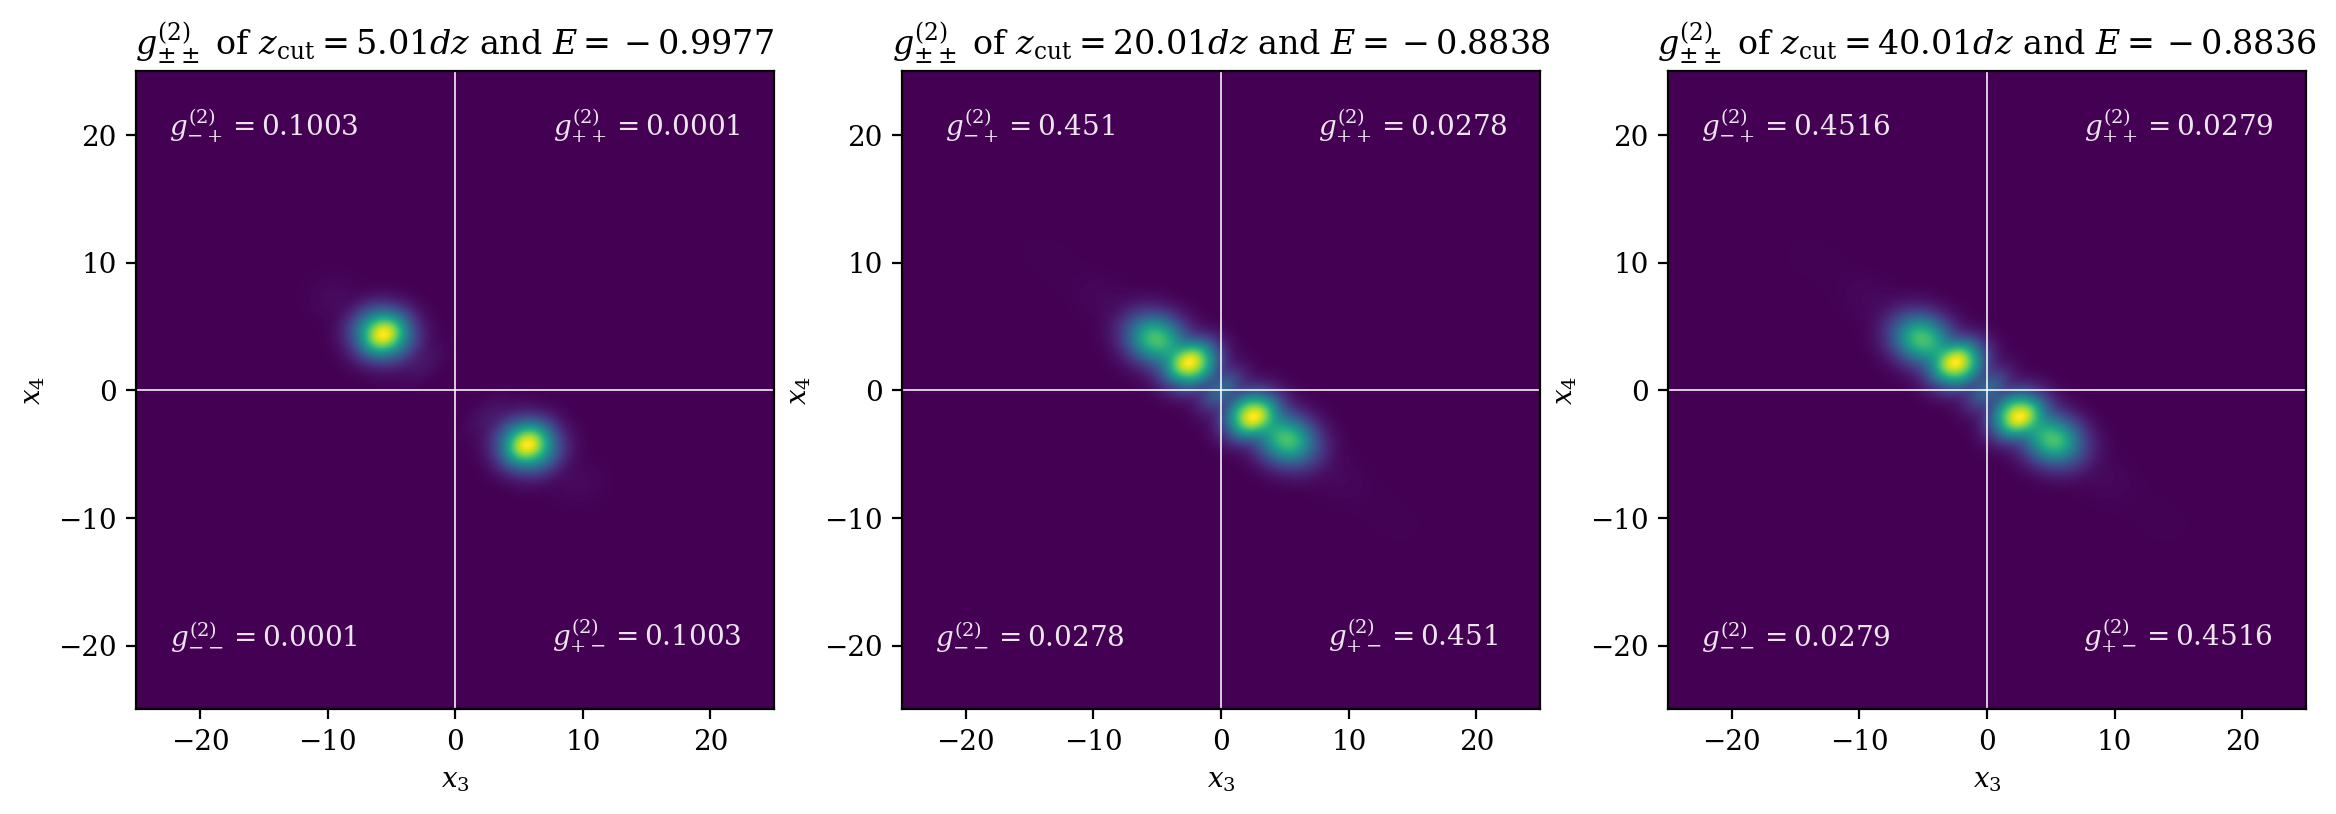

In [91]:
plt.figure(figsize=(14,6))

cut_list = [5.01, 20.01, 40.01]
for i in range(3):
    cut = cut_list[i]
    gx3x4 = gx3x4_calc(psi,cut=cut)
    plt.subplot(1,3,i+1)
    plot_gx3x4(gx3x4,cut)
plt.show()

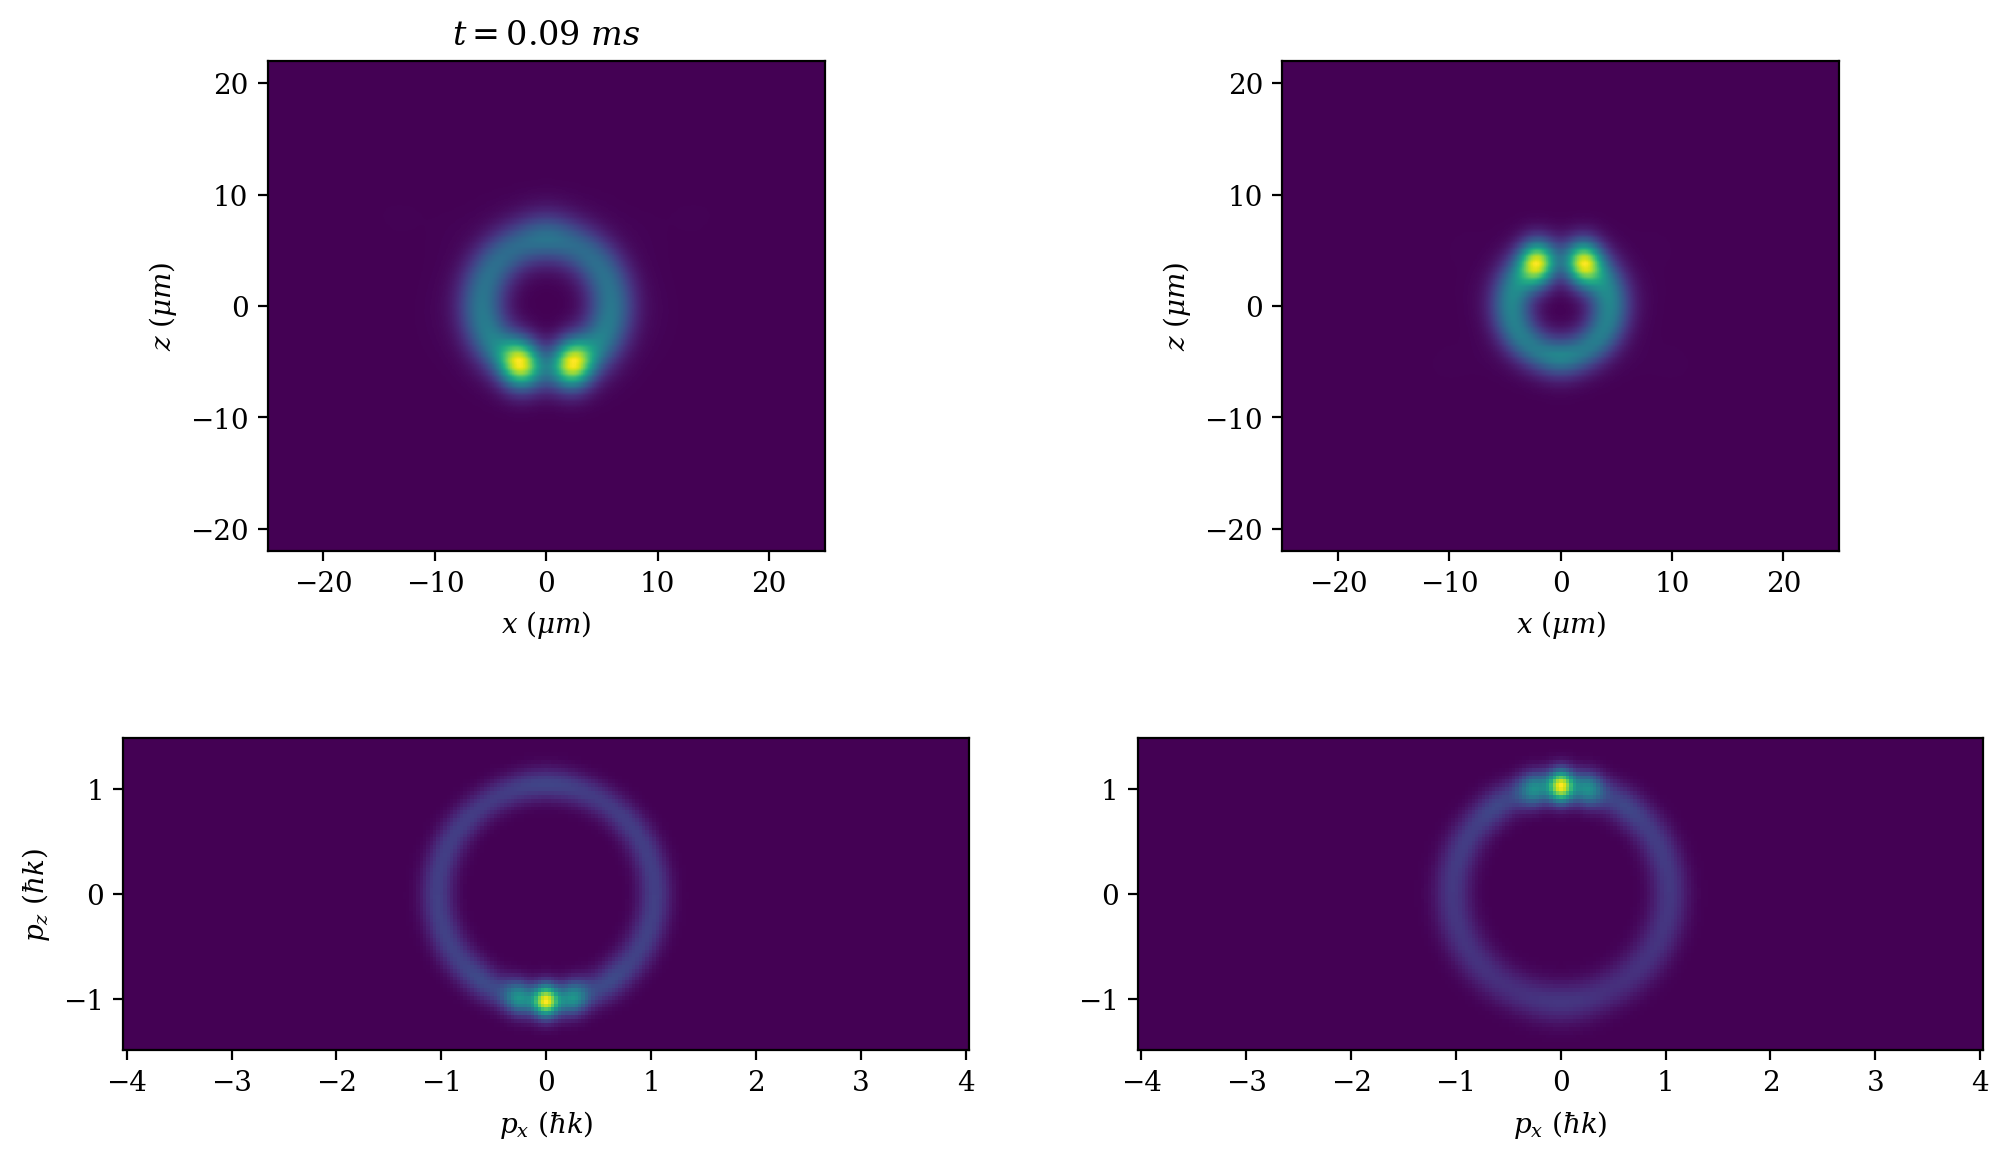

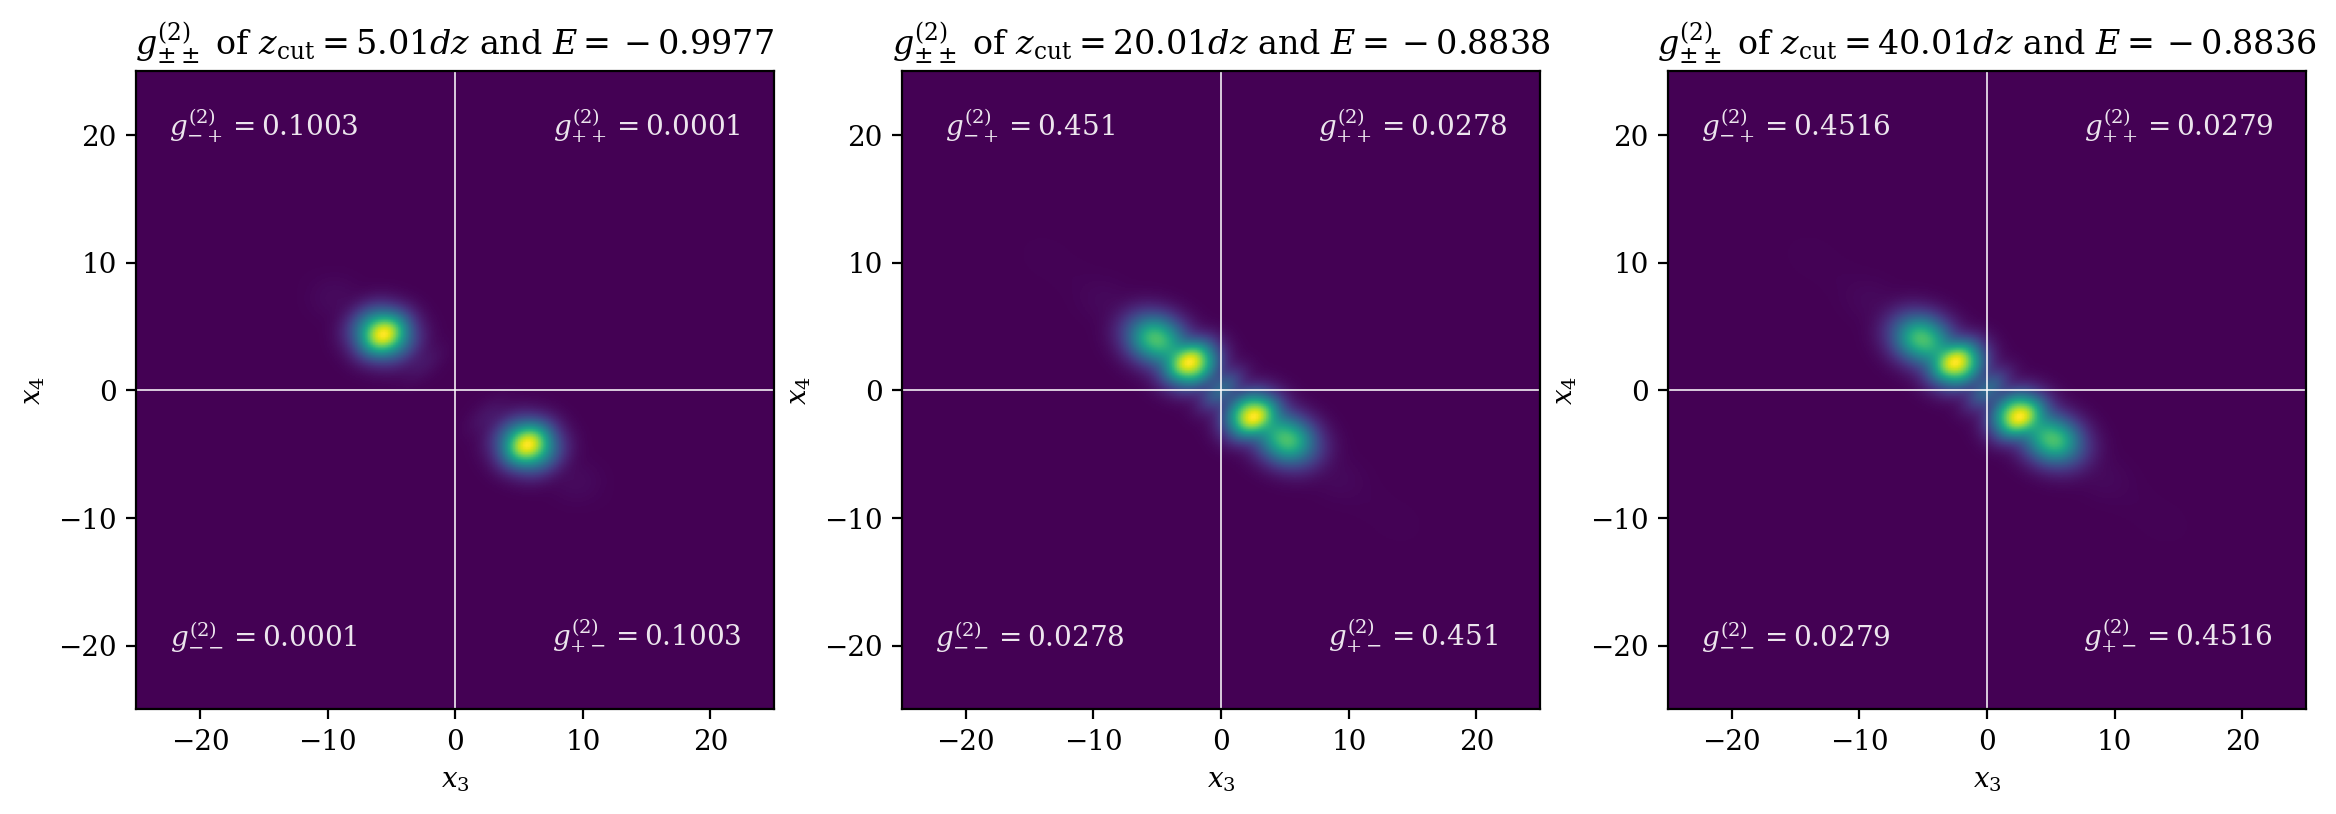

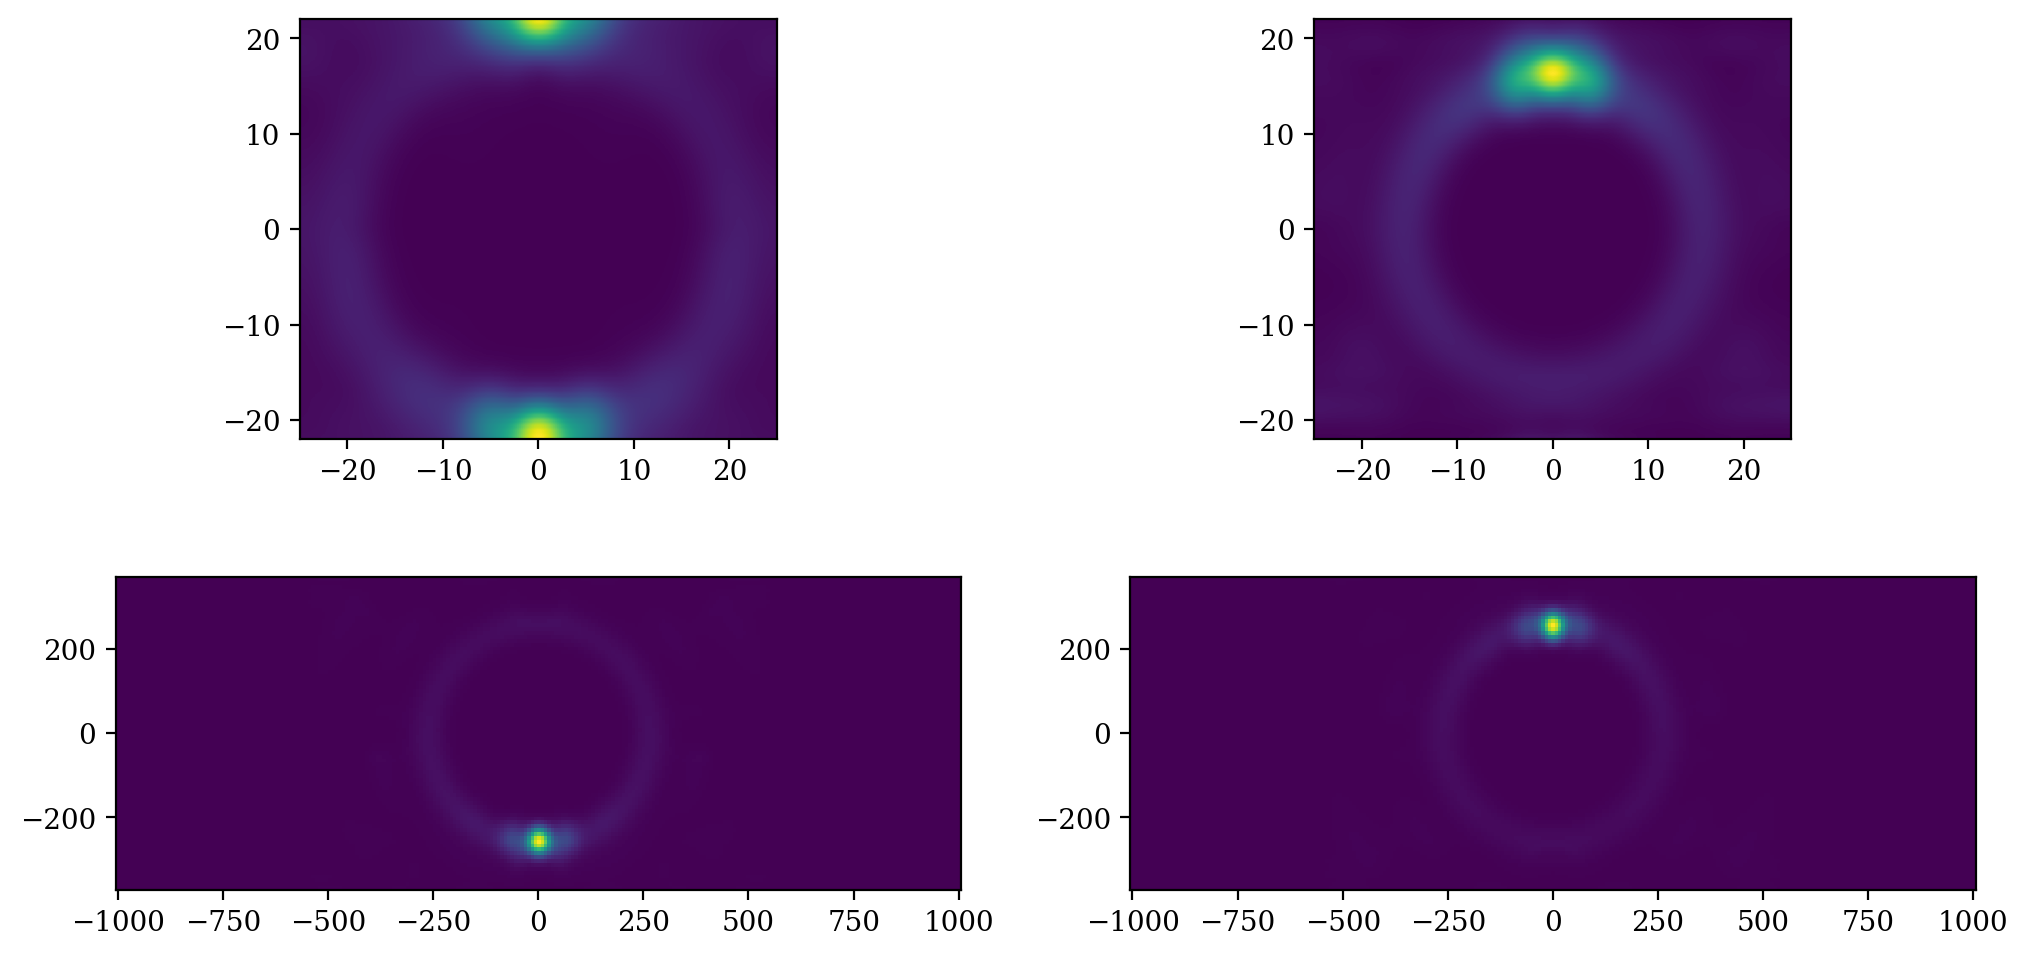
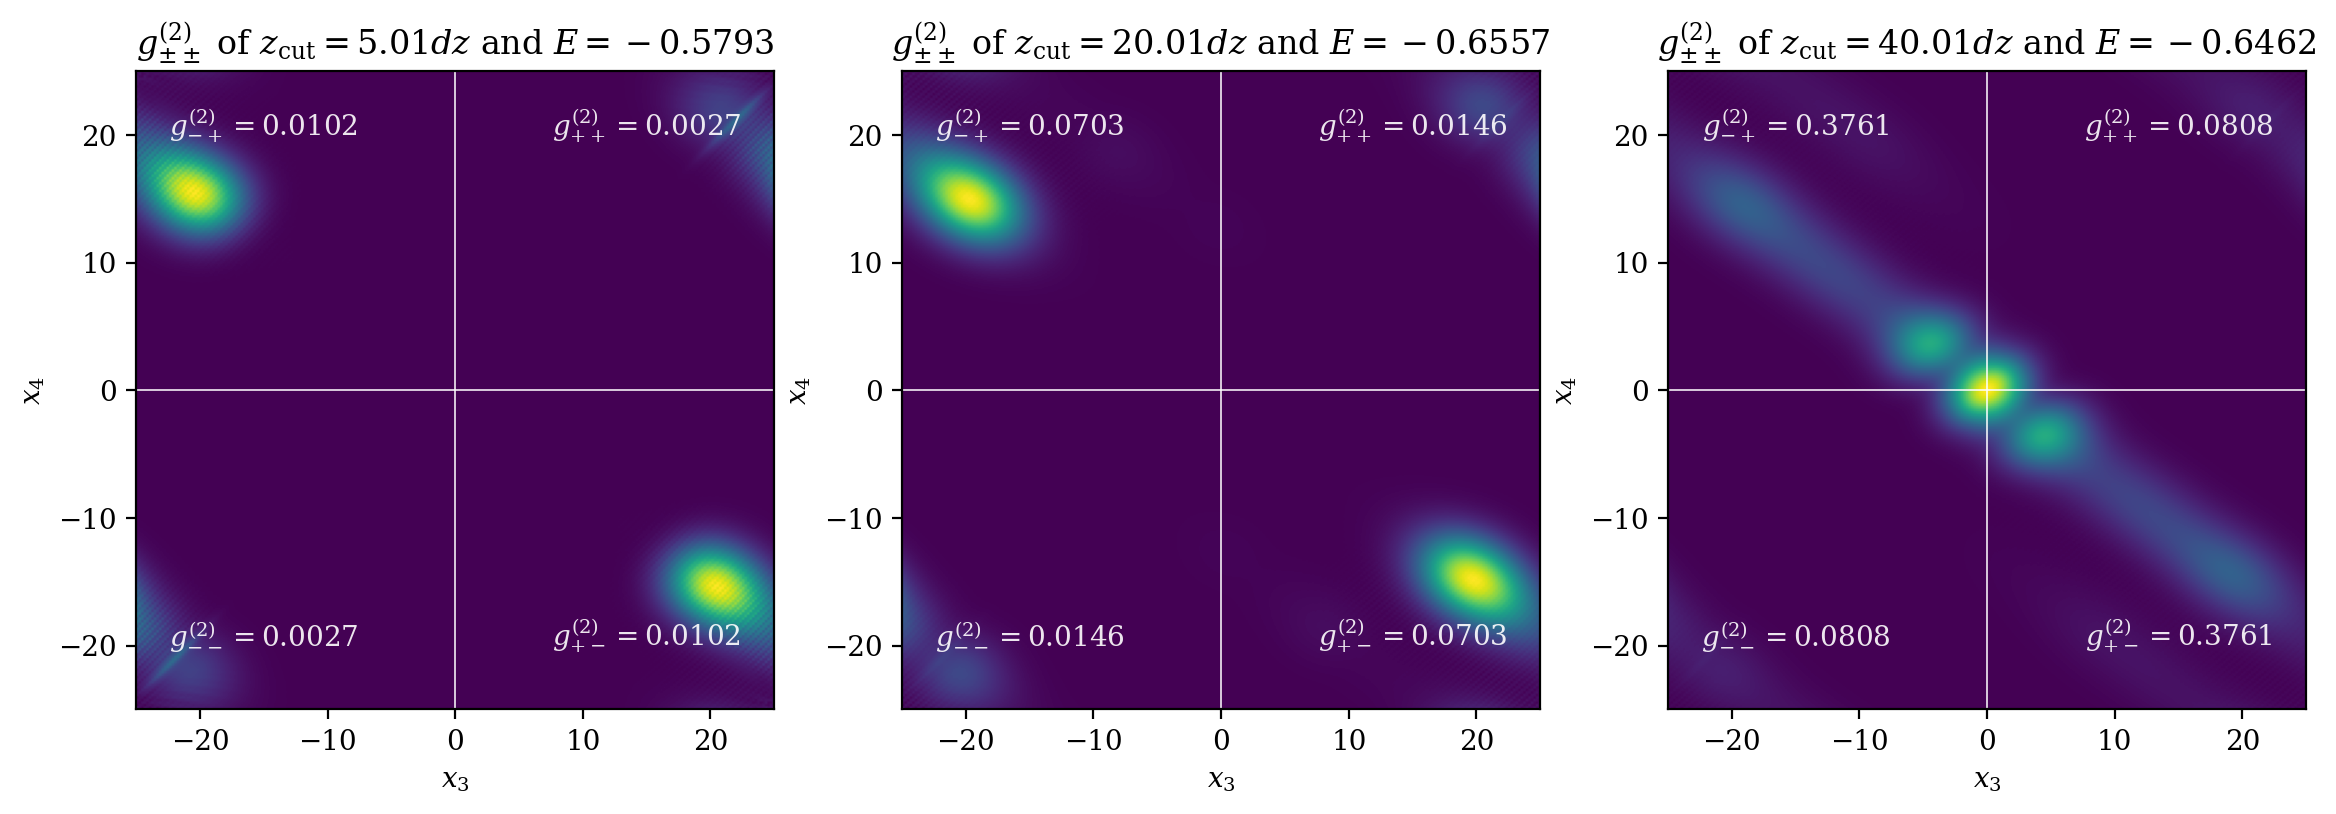




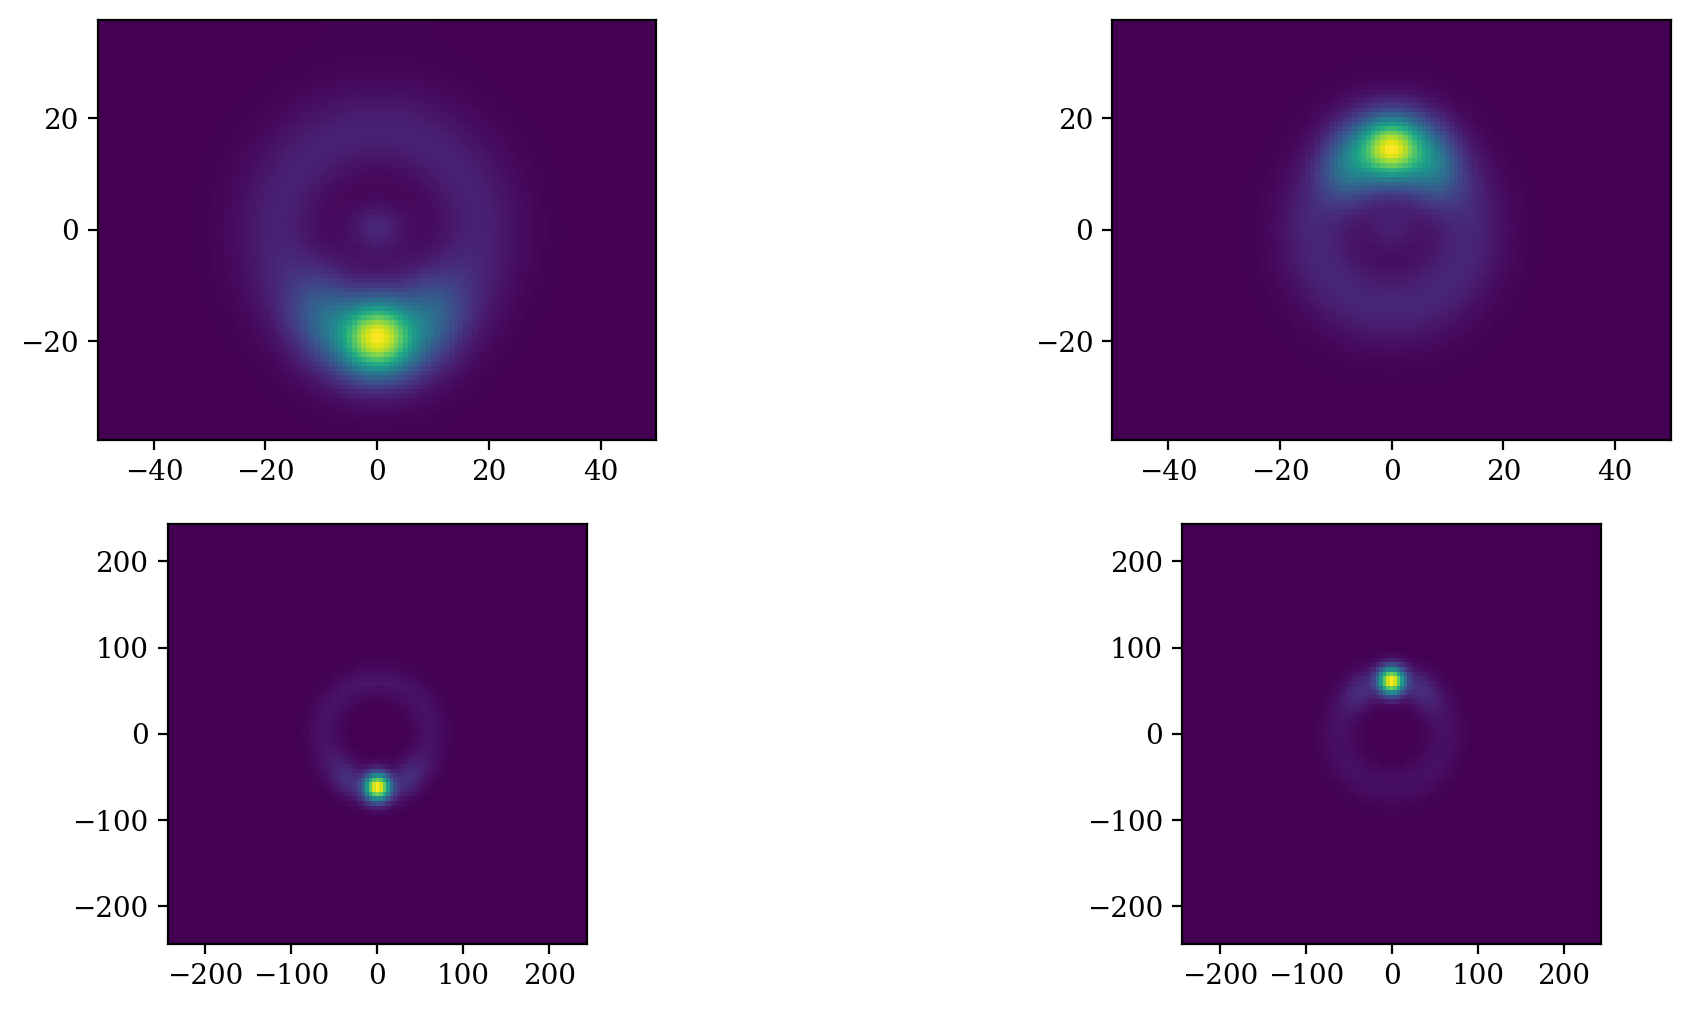
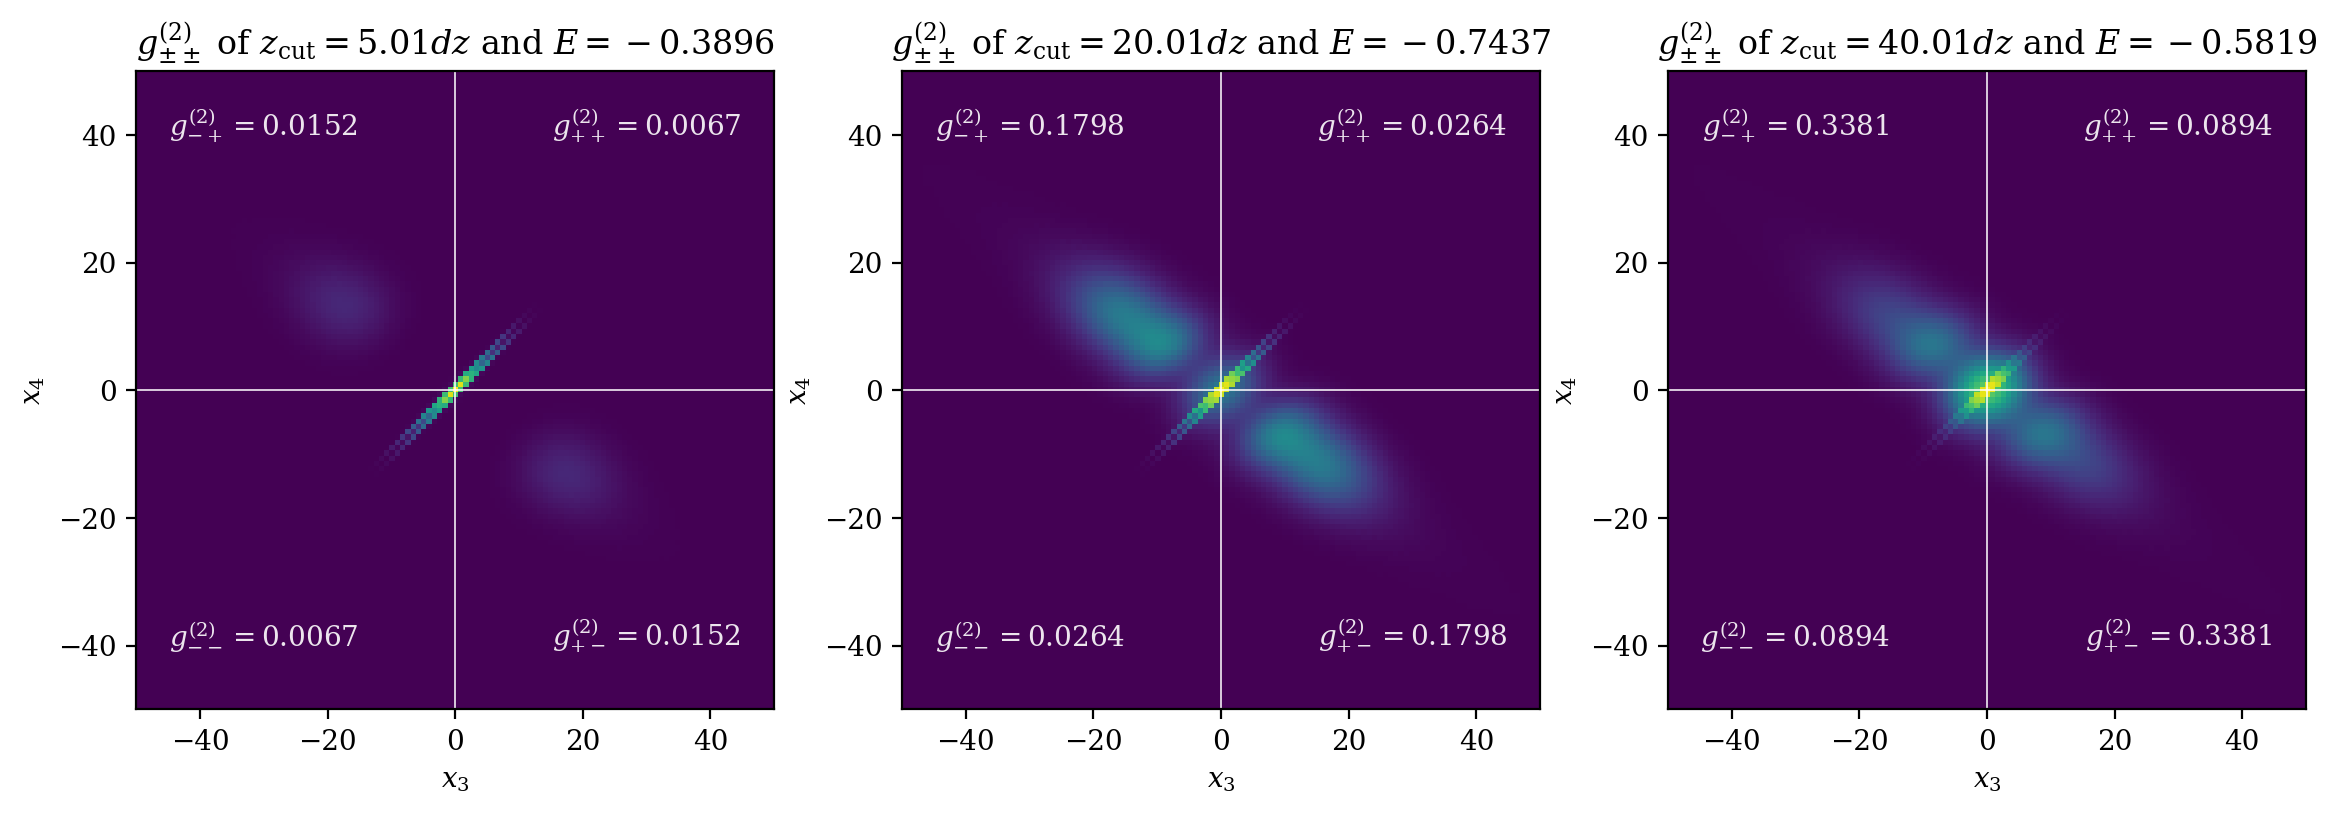

In [92]:
with pgzip.open(output_prefix+'(t,psi)'+output_ext, 'wb', thread=8, blocksize=1*10**8) as file:
    pickle.dump((t,psi), file) 

In [ ]:
gx3x4 = gx3x4_calc(psi,cut=cut)
plt.subplot(1,3,i+1)
plot_gx3x4(gx3x4,cut)
plt.show()

## Bragg Time Evolution Operator

In [40]:
def numericalEvolve_plotHelper(t, psi, phi):
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.imshow(np.flipud(only3(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,2)
    plt.imshow(np.flipud(only4(psi).T), extent=[-xmax,xmax,-zmax, zmax])

    plt.subplot(2,2,3)
    plt.imshow(np.flipud(only3phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.subplot(2,2,4)
    plt.imshow(np.flipud(only4phi(phi).T), extent=[-pxmax,pxmax,-pzmax,pzmax])

    plt.show()

def numericalEvolve(
        t_init, 
        psi_init, 
        t_final, 
        tPi  = tBraggPi, 
        tMid = tBraggPi*5, 
        V0FArg=V0F,
        phase  = 0,
        doppd=dopd,
        print_every_t=-1, 
        final_plot=True,
        progress_bar=True, 
    ):
    assert (print_every_t >= dt or print_every_t <= 0), "print_every_t cannot be smaller than dt"
    steps = ceil((t_final - t_init) / dt) 
    t = t_init
    psi = psi_init.copy()
    del psi_init
#     psi = psi_init
    (phi, swnf) = phiAndSWNF(psi)

    def loop():
        nonlocal t
        nonlocal psi
        nonlocal phi
        Vx3ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x3grid + doppd*(t-tMid) + phase) )
        Vx4ExpGrid = np.exp(-(1j/hb) * 0.5*dt * VBF(t,tMid,tPi,V0FArg) * 
                            np.cos(2*k*x4grid + doppd*(t-tMid) + phase) )
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        phi = toPhi(psi,swnf)
        phi *= expP3Grid
        phi *= expP4Grid
        psi = toPsi(phi,swnf)
        psi *= Vx3ExpGrid
        psi *= Vx4ExpGrid
        
        t += dt 
        
    if progress_bar:
        for step in tqdm(range(steps)):
            loop()
            print("finished step =", step, "\t memory used: " + 
                  str(round(current_py_memory()/1000**2,3)) + "MB  ", end='\r');
            if print_every_t > 0 and step % round(print_every_t / dt) == 0: 
                numericalEvolve_plotHelper(t, psi, phi)
    else:
        for step in range(steps):
            loop()
    
    if final_plot:
        print("ALL DONE")
        numericalEvolve_plotHelper(t, psi, phi)
    return (t,psi,phi)

In [31]:
su = 5
(t_try1, psi_try1, phi_try1) = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=0, pz3=0, px4=0, pz4=0), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=1*V0F, phase=0, doppd=-10*dopd, 
                print_every_t=0*dt, final_plot=False, progress_bar=True)

NameError: name 'numericalEvolve' is not defined

Notes

`V0FArg=1*V0F, phase=0, doppd=-10*dopd` doesn't quite work with `tauPi = 0.0039`

`V0FArg=2*V0F, phase=0, doppd=-10*dopd` worked ish

`V0FArg=3*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=4*V0F, phase=0, doppd=-10*dopd` worked

`V0FArg=10*V0F, phase=0, doppd=-10*dopd` might be too fast

The problem with these are they don't have transfers

then I realised I set the doppler frequency different incorrectly ....

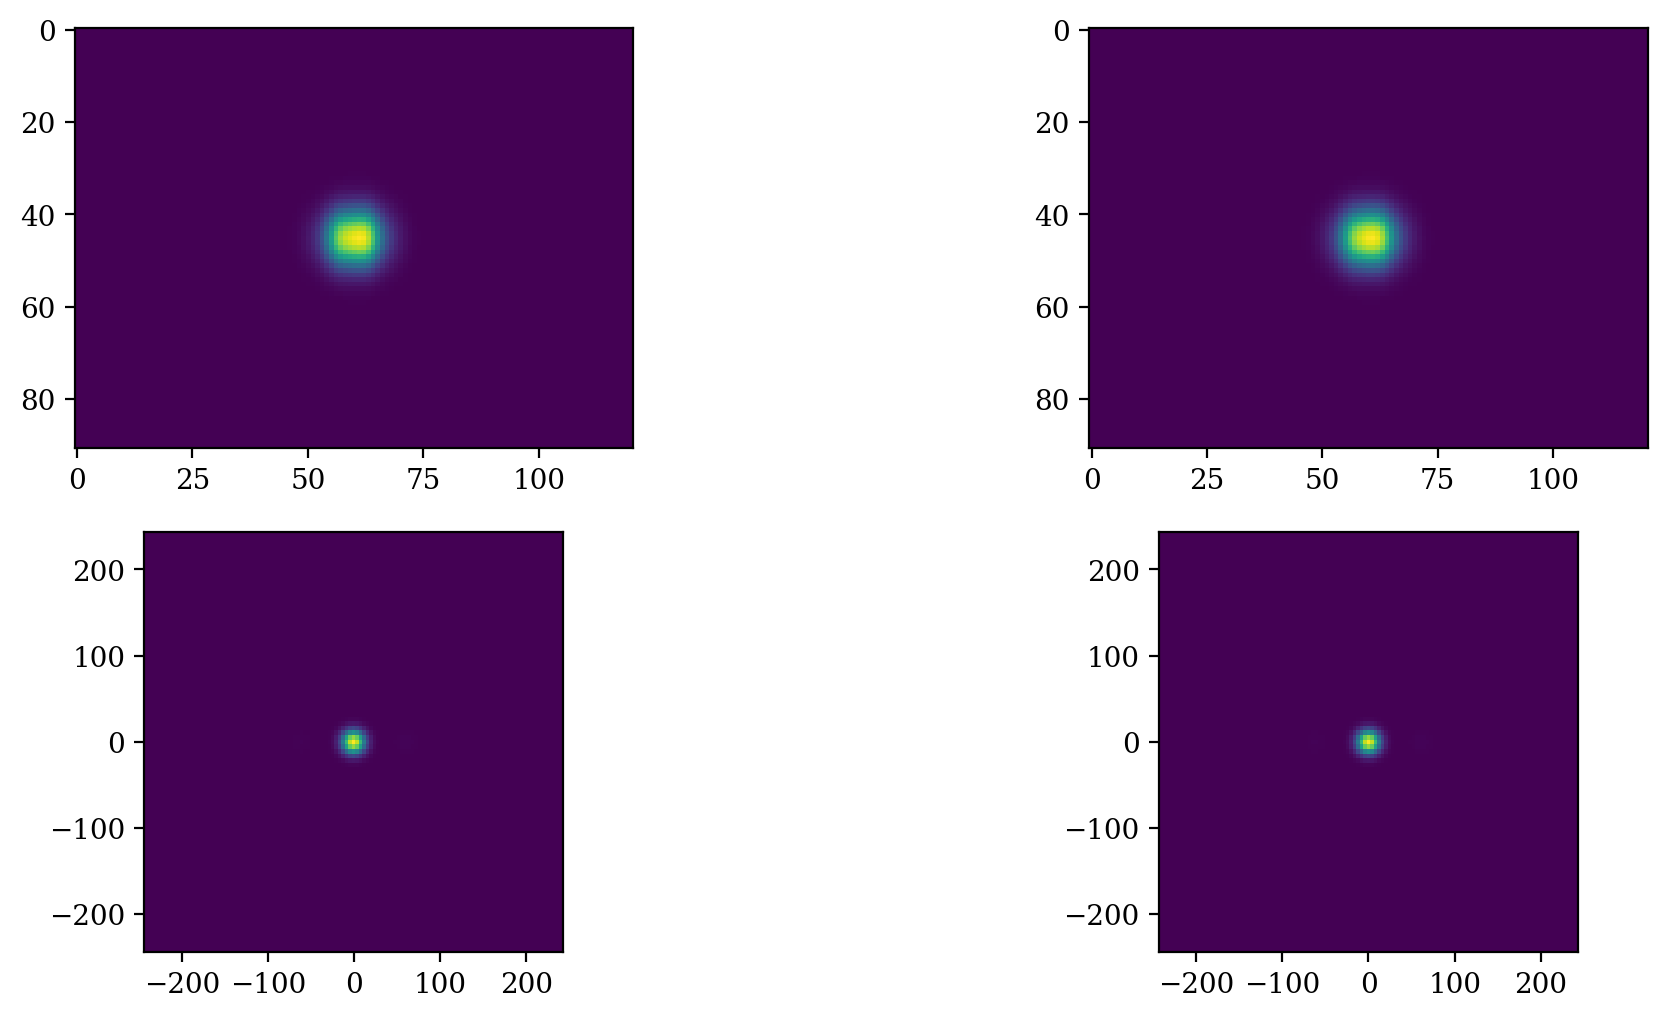

In [37]:
numericalEvolve_plotHelper(t_try1, psi_try1, phi_try1)

In [32]:
hbar_k_transfers = np.arange(-6,6+1)
pzlinIndexSet = np.zeros((len(hbar_k_transfers), len(pxlin)), dtype=bool)
# cut_p_width = 0.1
lr_include = 1
for (j, hbar_k) in enumerate(hbar_k_transfers):
#     pzlinIndexSet[j] = abs(pxlin/(hb*k) - hbar_k) <= cut_p_width

    index_unshift = round(hbar_k*(hb*k)/dpx)
    index = int(index_unshift + (nx-1)/2)
    for ishift in range(-lr_include, lr_include+1):
        pzlinIndexSet[j,index+ishift] = True
    
#     print(i,hbar_k, index)

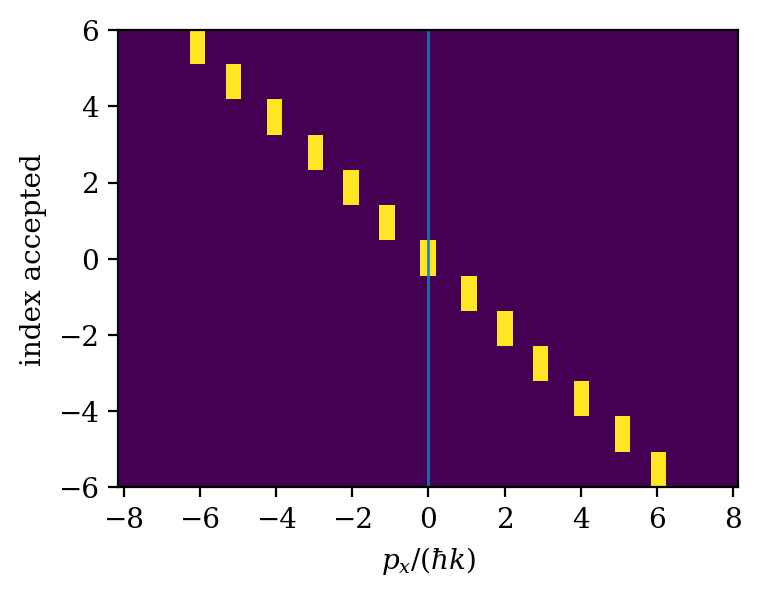

In [33]:
# plt.figure()
ax = plt.figure(figsize=(4,4)).gca()
plt.imshow(pzlinIndexSet,interpolation='none',aspect=1, extent=[-pxmax/(hb*k),pxmax/(hb*k),-6,+6])
# plt.axvline(x=(nx-1)/2, linewidth=1, alpha=0.1)
plt.axvline(x=0, linewidth=1, alpha=0.9)
plt.xlabel("$p_x/(\hbar k)$")
plt.ylabel("index accepted")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

title="hbar_k_pxlin_integration_range"
# plt.savefig("output/"+title+".pdf", dpi=600)
# plt.savefig("output/"+title+".png", dpi=600)
plt.show()

In [40]:
phiDensityGrid_hbark = np.zeros(len(hbar_k_transfers))

In [43]:
phiX3 = np.trapz(np.trapz(np.trapz( (np.abs(phi_try1)**2) , pzlin,axis=3),pxlin,axis=2),pzlin,axis=1)
for (j, hbar_k) in enumerate(hbar_k_transfers):
    index = pzlinIndexSet[j]
    phiDensityGrid_hbark[j] = np.trapz(phiX3[index], pxlin[index])

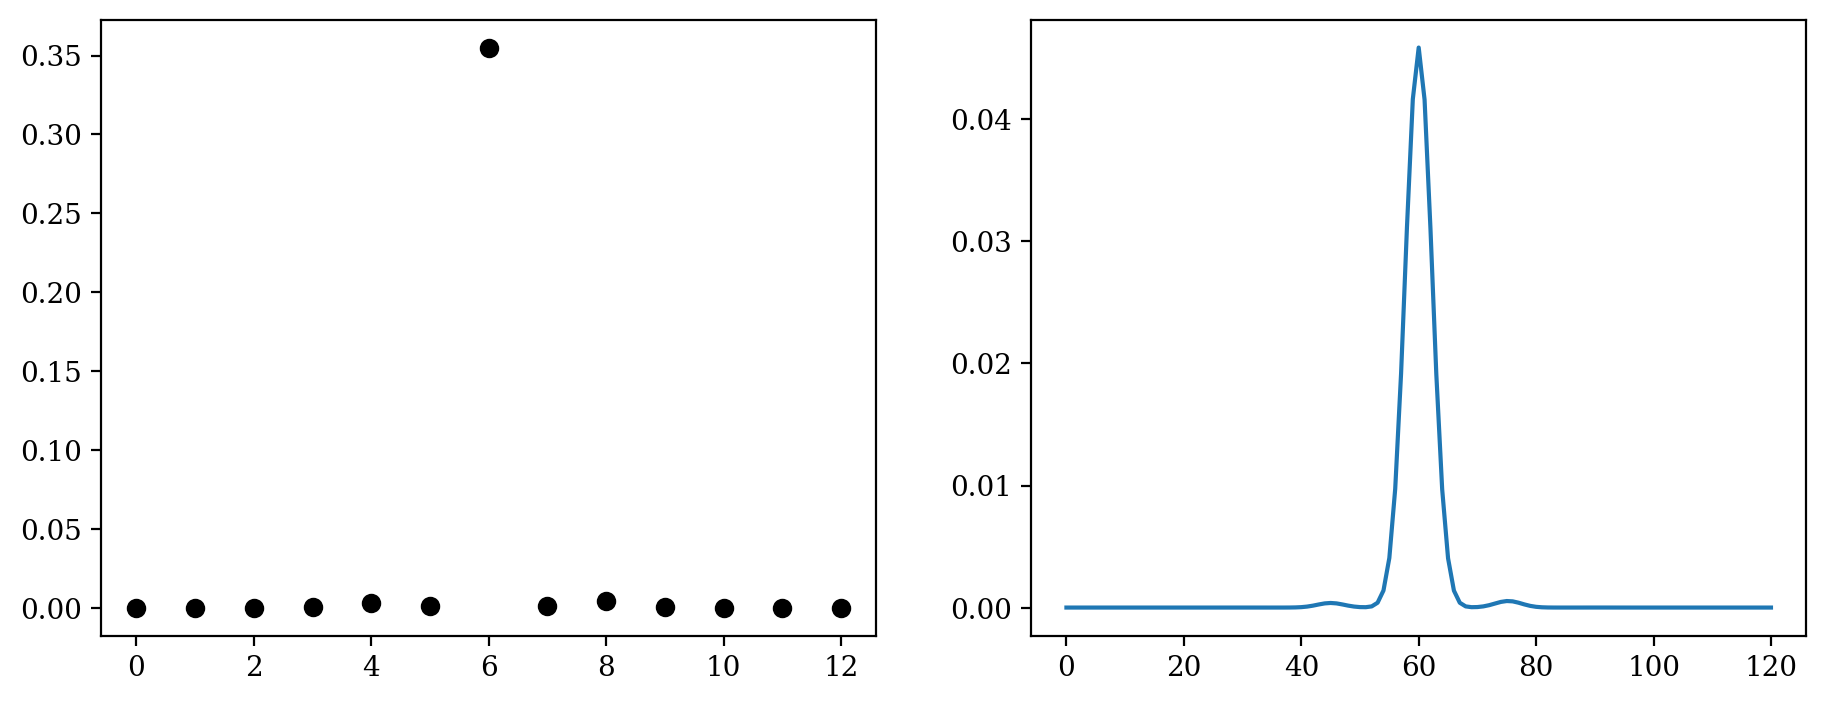

In [46]:
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(phiDensityGrid_hbark,'ko')
plt.subplot(1,2,2)
plt.plot(phiX3)

In [39]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
def scan_tauPi_init_gaussian(tPi, a3=0, a4=0, p3=0, p4=0, doppd=dopd, V0FArg=V0F, 
                             logging=False, progress_bar=False):
    tauPi  = tPi
    tauMid = tauPi * 5
    tauEnd = tauPi * 10
    px3 = p3*cos(a3)
    pz3 = p3*sin(a3)
    px4 = p4*cos(a4)
    pz4 = p4*sin(a4)
    
    if logging:
        print("Testing parameters")
        print("tauPi =", round(tPi,6), "    \t tauMid =", round(tauMid,6), " \t tauEnd = ", round(tauEnd,6))
    output = numericalEvolve(t_init=0, 
                psi_init=psi0gaussian(sx3=su, sz3=su, sx4=su, sz4=su, px3=px3, pz3=pz3, px4=px4, pz4=pz4), 
                t_final=tauEnd, tPi=tauPi, tMid=tauMid, V0FArg=V0FArg, phase=0, doppd=doppd, 
                print_every_t=0*dt, final_plot=False, progress_bar=progress_bar)
    

In [52]:
_ = scan_tauPi_init_gaussian(tauPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)

  0%|          | 0/39 [00:00<?, ?it/s]

In [53]:
tPiTest = np.append(np.arange(0.015,0,-dt), 0) # note this is decending
    # tPiTest = np.arange(dt,3*dt,dt)  

In [55]:
tPiTest[[1,2,3]]

array([0.014, 0.013, 0.012])

In [ ]:
tPiOutput = Parallel(n_jobs=N_JOBS)(
    delayed(lambda tPi: (tPi, scan_tauPi_init_gaussian(tPi,a3=0,a4=0,p3=0,p4=0,doppd=-10*dopd,V0FArg=V0F,
                             logging=False,progress_bar=True)
           )(tPi) 
    for tPi in tqdm(tPiTest)
)     

In [ ]:
phiDensityGrid = np.zeros((len(tPiTest), pxlin.size))
phiDensityGrid_hbark = np.zeros((len(tPiTest),len(hbar_k_transfers)))

for i in tqdm(range(len(tPiTest))):
    item = tPiOutput[i]
    (swnf, phi) = phiAndSWNF(item[1][1])
    phiAbsSq = np.abs(phi)**2
    phiX = np.trapz(phiAbsSq, pzlin,axis=1)
    phiDensityGrid[i] = phiX

    for (j, hbar_k) in enumerate(hbar_k_transfers):
        index = pzlinIndexSet[j]
        phiDensityGrid_hbark[i,j] = np.trapz(phiX[index], pxlin[index])